In [166]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import random as random
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
import geopy.distance

import plotly.express as px
import networkx as nx
import collections
import pickle
import plotly
import geopandas
from pycountry_convert import *
import imageio
from skimage import data
from PIL import Image
import base64
from io import BytesIO

import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import plot
from IPython.display import IFrame

## Table of Contents

* [Data Preprocessing](#chapter1)
    * [Load and Clean the data](#section_1_1)
        * [Statistics of data](#section_1_1_1)  
        * [Country Each user reside in](#section_1_1_2)  
    * [Create strangers](#section_1_2)
        * [Strangers from different countries](#section_1_2_1)
        * [Strangers from the same countries](#section_1_2_2)
    * [Find friends](#section_1_3)        
        * [Friends from different countries](#section_1_3_1)
        * [Friends from the same countries](#section_1_3_2)
    * [Find friends of friends, 2-5 edges away](#section_1_4)
        * [Friends from different countries](#section_1_4_1)
        * [Friends from the same countries](#section_1_4_2)
    
    
* [Research Questions I - Broad introduction](#chapter4)   
    1. [How does sociability affect one's mobility?](#section_4_1)
    2. [How does traveling distance affect one's mobility?](#section_4_2)
    
    
* [Research Questions II - Friendship and Mobility](#chapter2)
    1. [How similar it is between friends, strangers in different, same countries?](#section_2_1)
        * [Cosine Similarity](#section_2_1_1)
        * [Most Common Visited Location Types](#section_2_1_2)
    2. [How far away are the strangers?](#section_2_2)
        * [Cosine Similarity](#section_2_2_1)
        * [Most Common Visited Location Types](#section_2_2_2)
    3. [Are the friendships fading?](#section_2_3)
        * [Cosine Similarity](#section_2_3_1)
        * [Most Common Visited Location Types](#section_2_3_2)
 
 
* [Research Questions III - Country and Mobility](#chapter3)   
    1. [What are the popular visited location types (non-periodic) in different countries?](#section_3_1)
    2. [Seasonality - Will visited frequencies of popular location types change with time?](#section_3_2)
    3. [Case Study in US: What are the location types to meet strangers similar to you?](#section_3_3)
    4. [What are the periodic behaviors difference in different countries?](#section_3_4)

## Data Preprocessing<a class="anchor" id="chapter1"></a>
### Load and Clean the data <a class="anchor" id="section_1_1"></a>
#### Statistics of data<a class="anchor" id="section_1_1_1"></a>

In the beginning, let's take a look at how the data looks like. How many check-in data are there? How many location types are there? How many countries are included in the check-in data? How many pairs of old and new friendships are recorded?

In [2]:
checkIns = pd.read_csv("./dataset_WWW2019/dataset_WWW_Checkins_anonymized.txt", sep='\t', header=None)
checkIns.columns = ['UserID', 'LocationID', 'check-in time', 'Timezone offset']

raw_POIs = pd.read_csv("./dataset_WWW2019/raw_POIs.txt", sep='\t', header=None)
raw_POIs.columns = ['LocationID', 'lat', 'lon', 'Location Type', 'Country Code']

In [3]:
checkIns.head(5)

,UserID,LocationID,check-in time,Timezone offset
0,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
1,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
2,113817,4b4bade2f964a520cfa326e3,Tue Apr 03 18:00:09 +0000 2012,-240
3,14732,4c143cada5eb76b0dc7dc1b7,Tue Apr 03 18:00:09 +0000 2012,-240
4,1397630,4e88cf4ed22d53877981fdab,Tue Apr 03 18:00:09 +0000 2012,-300


In [4]:
raw_POIs.head(5)

,LocationID,lat,lon,Location Type,Country Code
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US


In [5]:
print("There are " + str(len(checkIns)) + " of check-in data.")
print("There are " + str(raw_POIs.LocationID.unique().shape[0]) + " unique location ID, with " +\
      str(raw_POIs['Location Type'].unique().shape[0]) + " unique location types.")
print("Locations are from " + str(raw_POIs['Country Code'].unique().shape[0]) + " countries.")

There are 22809624 of check-in data.
There are 11180160 unique location ID, with 519 unique location types.
Locations are from 254 countries.


In [6]:
oldFriendship = pd.read_csv("./dataset_WWW2019/dataset_WWW_friendship_old.txt", sep='\t', header=None)
oldFriendship.columns = ['user', 'friend']

newFriendship = pd.read_csv("./dataset_WWW2019/dataset_WWW_friendship_new.txt", sep='\t', header=None)
newFriendship.columns = ['user', 'friend']

In [7]:
oldFriendship.head(5)

,user,friend
0,15,595326
1,19,54
2,19,1061
3,19,1356
4,19,1668


In [8]:
print("There are pairs of " + str(len(oldFriendship)) + " friendships before the check-in data being collected.")

There are pairs of 363704 friendships before the check-in data being collected.


In [9]:
newFriendship.head(5)

,user,friend
0,15,595326
1,19,54
2,19,1061
3,19,1668
4,19,21596


In [10]:
newFriendship_ = (pd.merge(newFriendship, oldFriendship, indicator=True, how='outer')
                 .query('_merge == "left_only"')
                 .drop('_merge', axis=1))
newFriendship_.head(5)

,user,friend
4,19,21596
7,19,38369
9,19,39628
10,19,51332
14,19,127930


In [11]:
print("There are pairs of " + str(len(newFriendship)) + " friendships after the check-in data being collected, where " + str(len(newFriendship_)) + ' are newly created.')

There are pairs of 607333 friendships after the check-in data being collected, where 337613 are newly created.


In [12]:
## change the check-in time into datetime object
r = re.compile('.* .* .* .*:.*:.* .* .*')
checkIns['format'] = checkIns['check-in time'].apply(lambda x: True if r.match(x) is not None else False)
checkIns = checkIns[checkIns['format'] == True]
checkIns['check-in-time'] = checkIns['check-in time'].apply(lambda x: datetime.strptime(x, '%a %b %d %H:%M:%S +%f %Y'))
checkIns['check-in-time'] = checkIns.apply(lambda x: x['check-in-time'] + timedelta(minutes=x['Timezone offset']), axis = 1)
# checkIns = pd.read_pickle("./checkIns.pkl")
checkIns.head(5)

,UserID,LocationID,check-in time,Timezone offset,format,check-in-time
0,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180,True,2012-04-03 21:00:07
1,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,True,2012-04-03 13:00:08
2,113817,4b4bade2f964a520cfa326e3,Tue Apr 03 18:00:09 +0000 2012,-240,True,2012-04-03 14:00:09
3,14732,4c143cada5eb76b0dc7dc1b7,Tue Apr 03 18:00:09 +0000 2012,-240,True,2012-04-03 14:00:09
4,1397630,4e88cf4ed22d53877981fdab,Tue Apr 03 18:00:09 +0000 2012,-300,True,2012-04-03 13:00:09


In [13]:
## merge the check-in data with location information
fullData = pd.merge(checkIns, raw_POIs, left_on = 'LocationID', right_on = 'LocationID')
# fullData = pd.read_pickle("./fullData.pkl")
fullData.head(5)

,UserID,LocationID,check-in time,Timezone offset,format,check-in-time,lat,lon,Location Type,Country Code
0,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180,True,2012-04-03 21:00:07,41.029717,28.97442,Bar,TR
1,1625020,4b4b87b5f964a5204a9f26e3,Wed Apr 04 14:05:22 +0000 2012,180,True,2012-04-04 17:05:22,41.029717,28.97442,Bar,TR
2,1269425,4b4b87b5f964a5204a9f26e3,Wed Apr 04 16:34:17 +0000 2012,180,True,2012-04-04 19:34:17,41.029717,28.97442,Bar,TR
3,142452,4b4b87b5f964a5204a9f26e3,Wed Apr 04 18:05:45 +0000 2012,180,True,2012-04-04 21:05:45,41.029717,28.97442,Bar,TR
4,807242,4b4b87b5f964a5204a9f26e3,Wed Apr 04 18:13:09 +0000 2012,180,True,2012-04-04 21:13:09,41.029717,28.97442,Bar,TR


In [14]:
## filter out periodic behaviors, as we will investigate the research questions in non-periodic behavior first.
locations = ['Home (private)', 'Office', 'Airport']
fullData_nonPeriodic = fullData.dropna()
fullData_nonPeriodic = fullData_nonPeriodic.replace(to_replace=r'^Caf.*.*$', value='Cafeteria', regex=True)
fullData_nonPeriodic = fullData_nonPeriodic[~fullData_nonPeriodic['Location Type'].isin(locations)]
# fullData_nonPeriodic = pd.read_pickle("./fullData_nonPeriodic.pkl")
fullData_nonPeriodic.head(5)

,UserID,LocationID,check-in time,Timezone offset,format,check-in-time,lat,lon,Location Type,Country Code
0,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180,True,2012-04-03 21:00:07,41.029717,28.97442,Bar,TR
1,1625020,4b4b87b5f964a5204a9f26e3,Wed Apr 04 14:05:22 +0000 2012,180,True,2012-04-04 17:05:22,41.029717,28.97442,Bar,TR
2,1269425,4b4b87b5f964a5204a9f26e3,Wed Apr 04 16:34:17 +0000 2012,180,True,2012-04-04 19:34:17,41.029717,28.97442,Bar,TR
3,142452,4b4b87b5f964a5204a9f26e3,Wed Apr 04 18:05:45 +0000 2012,180,True,2012-04-04 21:05:45,41.029717,28.97442,Bar,TR
4,807242,4b4b87b5f964a5204a9f26e3,Wed Apr 04 18:13:09 +0000 2012,180,True,2012-04-04 21:13:09,41.029717,28.97442,Bar,TR


#### Country each user reside in <a class="anchor" id="section_1_1_2"></a>

In our research questions, we split friends and strangers into people from the same or different country. We define the home location of each user the country they reside in. Note that country of residence might be different from country of origin. However, we lack the information of country of origin, and will refer the country in the following as the country of residence.

In [15]:
## take users who have friends and create strangers for them
user = list(fullData_nonPeriodic.UserID.unique())
userWithFriend1 = list(oldFriendship.user.unique())
userWithFriend2 = list(oldFriendship.friend.unique())
usersWithFriends = list(set(userWithFriend1 + userWithFriend2))

In [16]:
## compute the country of each user
CountryAndItsUsers = fullData_nonPeriodic[['UserID', 'Country Code']]
CountryAndItsUsers = CountryAndItsUsers.groupby("Country Code").agg({'UserID': lambda x: list(x)}).reset_index()
CountryAndItsUsers['UserID'] = CountryAndItsUsers['UserID'].apply(lambda x: list(set(x)))
CountryAndItsUsers.head(5)

,Country Code,UserID
0,AD,"[1081348, 370693, 724998, 78857, 739362, 51101..."
1,AE,"[540692, 1589269, 401446, 1876021, 598078, 188..."
2,AF,"[164289, 154306, 229347, 1315874, 62273, 64394..."
3,AG,"[89763, 62179, 219747, 75274, 514475, 395403, ..."
4,AI,"[156167, 375144, 135404, 472558, 151377, 9490,..."


In [17]:
## the country dict for each user
CountryAndItsUsers_dict = dict(CountryAndItsUsers.values.tolist())
User_Country_dict = dict(fullData_nonPeriodic[['UserID', 'Country Code']].drop_duplicates().values.tolist())

### Create strangers <a class="anchor" id="section_1_2"></a>
#### Strangers from different countries <a class="anchor" id="section_1_2_1"></a>

For each user with friends, we sample several other users as the strangers. Then, we exclude the pairs who are in the same country, and who are already friends.

In [18]:
## sample strangers for each users
randomStrangers = pd.DataFrame(usersWithFriends, columns = ['user'])
randomStrangers['stranger'] = [random.sample(user, 3) for i in range(len(usersWithFriends))]
randomStrangers = randomStrangers.explode('stranger')
randomStrangers['user_country'] = randomStrangers['user'].apply(lambda x: User_Country_dict[x])
randomStrangers['stranger_country'] = randomStrangers['stranger'].apply(lambda x: User_Country_dict[x])

In [19]:
## exclude those pairs who are in the same country / who are already friends
oldFriendship_ = oldFriendship.rename(columns={"friend": "stranger"})
randomStrangers = pd.concat([randomStrangers, oldFriendship_, oldFriendship_]).drop_duplicates(keep=False)
randomStrangers = randomStrangers[randomStrangers['user_country'] != randomStrangers['stranger_country']]
randomStrangers.head(5)

,user,stranger,user_country,stranger_country
0,1310720,227221,GR,CL
0,1310720,528240,GR,BR
0,1310720,1281235,GR,MY
1,786436,256549,TR,US
1,786436,561932,TR,ID


#### Strangers from same countries <a class="anchor" id="section_1_2_2"></a>

For each user with friends, we first take users from the same country. Then we exclude those who are already friends.

In [20]:
## sample strangers from the same country for each users and exclude those who are already friends
strangerFromSameCountries = pd.DataFrame(usersWithFriends, columns = ['user'])
strangerFromSameCountries['strangers'] = strangerFromSameCountries['user'].apply(lambda x: (CountryAndItsUsers_dict[User_Country_dict[x]]))
strangerFromSameCountries['len'] = strangerFromSameCountries['strangers'].apply(lambda x: len(x))
strangerFromSameCountries = strangerFromSameCountries[strangerFromSameCountries['len'] > 2]
strangerFromSameCountries['stranger'] = strangerFromSameCountries['strangers'].apply(lambda x: random.sample(x, 3))
strangerFromSameCountries = strangerFromSameCountries[['user', 'stranger']].explode('stranger')
strangerFromSameCountries = pd.concat([strangerFromSameCountries, oldFriendship_, oldFriendship_]).drop_duplicates(keep=False)
strangerFromSameCountries.head(5)

,user,stranger
0,1310720,916176
0,1310720,919806
0,1310720,1931409
1,786436,634945
1,786436,1480016


### Find friends <a class="anchor" id="section_1_3"></a>
#### Friends from different countries <a class="anchor" id="section_1_3_1"></a>

In [21]:
## split friends into two groups, from same country and different country
def splitUserIntoDifferentCountries(df):
    df.dropna(inplace = True)
    df['user_country'] = df['user'].apply(lambda x: User_Country_dict[x])
    df['friend_country'] = df['friend'].apply(lambda x: User_Country_dict[x])

    df_sameCountry = df[df['user_country'] == df['friend_country']]
    df_diffCountry = df[df['user_country'] != df['friend_country']]
    return df_sameCountry, df_diffCountry
oldFriendship_sameCountry, oldFriendship_diffCountry = splitUserIntoDifferentCountries(oldFriendship)
oldFriendship_diffCountry.head(5)

,user,friend,user_country,friend_country
1,19,54,FR,IE
2,19,1061,FR,US
3,19,1356,FR,NL
4,19,1668,FR,US
5,19,29643,FR,US


#### Friends from same countries <a class="anchor" id="section_1_3_2"></a>

In [22]:
oldFriendship_sameCountry.head(5)

,user,friend,user_country,friend_country
0,15,595326,US,US
8,19,47497,FR,FR
19,39,241256,US,US
30,58,58,FR,FR
39,75,8920,PH,PH


### Find friends of friends, 2-5 edges away <a class="anchor" id="section_1_4"></a>

We could like to see how far are the strangers in terms of similarity? Are "friends of friends" already a stranger? If not, how similar is it between one user and his/her friends's friends. Create a graph with networkx and place each user as the node, friendship as the edge. Find nodes that are 2-5 edges away from one node. Define them as friendship 2-5 edges away.

In [23]:
G = nx.Graph()
for idx, row in oldFriendship.iterrows():
    G.add_weighted_edges_from([(row['user'], row['friend'], 1)])

friendDict = collections.defaultdict(dict)
for user in usersWithFriends:
    for k in range(6):
        friendDict[user][k] = []
        
idx = 0
for user in usersWithFriends:
    path = nx.single_source_shortest_path(G, user, 5)
    for key, value in path.items():
        friendDict[user][len(value) - 1].append(key)
    idx += 1

dfFriend = pd.DataFrame.from_dict(friendDict, orient='index').reset_index()
for col in dfFriend.columns[1:]:
    dfFriend[col] = dfFriend[col].apply(lambda x: list(set(x)))
    
# dfFriend = pd.read_pickle("./dfFriend_.pkl")
dfFriend.columns = ['user', 'zero', 'one', 'two', 'three', 'four', 'five', 'six']
dfFriend.head(5)

,user,zero,one,two,three,four,five,six
0,1310720,[1310720],[1807133],[607633],"[1245004, 530256, 1725777, 713332, 813206, 147...","[807047, 1887496, 744073, 890636, 559630, 6354...","[1886209, 516098, 311300, 786436, 1122323, 107...","[1671171, 737283, 1384453, 786442, 1622029, 13..."
1,786436,[786436],"[775842, 939298, 932103, 1091849, 686196, 1374...","[801666, 785411, 1088901, 1451528, 1247625, 77...","[821248, 1886209, 516098, 737283, 446467, 1384...","[1671171, 786442, 1212443, 65580, 1146928, 121...","[1310720, 655365, 229381, 1966086, 32780, 1638...","[1179648, 393224, 917516, 524302, 15, 131092, ..."
2,786439,[786439],[812255],"[458178, 560741, 226608, 459633, 308052, 87794...","[706564, 229381, 274447, 40977, 253969, 811032...","[573440, 1466371, 655365, 475143, 1187848, 237...","[327684, 229380, 753670, 1081348, 1736712, 327...","[1179648, 393224, 19, 1179668, 393239, 1179683..."
3,524295,[524295],[449395],"[585601, 798627, 159020, 57453, 327501, 280191...","[30212, 1004037, 1037832, 251404, 984593, 4295...","[847873, 870403, 90115, 1822728, 847882, 58778...","[1736709, 794630, 245766, 237573, 319498, 4097...","[655365, 393224, 15, 262164, 1179683, 524329, ..."
4,786442,[786442],[928021],"[417505, 2102147, 457675, 1379179, 1505938, 56...","[801666, 1091849, 667403, 926859, 1080591, 128...","[839681, 516098, 737283, 786436, 1202184, 2049...","[1671171, 311300, 843780, 1064977, 1720337, 18...","[1310720, 1277972, 32793, 1212443, 1703964, 18..."


In [24]:
oldFriendship_2 = dfFriend_[['user', 'two']]
oldFriendship_2 = oldFriendship_2.explode('two').rename(columns = {'two': 'friend'})

oldFriendship_3 = dfFriend_[['user', 'three']]
oldFriendship_3 = oldFriendship_3.explode('three').rename(columns = {'three': 'friend'})

oldFriendship_4 = dfFriend_[['user', 'four']]
oldFriendship_4 = oldFriendship_4.explode('four').rename(columns = {'four': 'friend'})

# friendship 5 edges away are too big, resample them to get part of the data
oldFriendship_5 = dfFriend_[['user', 'five']]
oldFriendship_5 = oldFriendship_5.sample(frac=0.05, replace=True, random_state=1)
oldFriendship_5 = oldFriendship_5.explode('five').rename(columns = {'five': 'friend'})

In [25]:
# oldFriendship_2 = pd.read_pickle("./oldFriendship_2.pkl")
# oldFriendship_3 = pd.read_pickle("./oldFriendship_3.pkl")
# oldFriendship_4 = pd.read_pickle("./oldFriendship_4.pkl")
# oldFriendship_5 = pd.read_pickle("./oldFriendship_5.pkl")
oldFriendship_2.head(5)

,user,friend
0,1310720,607633
1,786436,801666
1,786436,785411
1,786436,1088901
1,786436,1451528


#### Friends from different countries <a class="anchor" id="section_1_4_1"></a>

In [27]:
oldFriendship_2_sample = oldFriendship_2.sample(frac=0.01, replace=True, random_state=1)
oldFriendship_3_sample = oldFriendship_3.sample(frac=0.003, replace=True, random_state=1)
oldFriendship_4_sample = oldFriendship_4.sample(frac=0.001, replace=True, random_state=1)
oldFriendship_5_sample = oldFriendship_5.sample(frac=0.005, replace=True, random_state=1)

## split the friendship into different / same country
oldFriendship_2_sameCountry, oldFriendship_2_diffCountry = splitUserIntoDifferentCountries(oldFriendship_2_sample)
oldFriendship_3_sameCountry, oldFriendship_3_diffCountry = splitUserIntoDifferentCountries(oldFriendship_3_sample)
oldFriendship_4_sameCountry, oldFriendship_4_diffCountry = splitUserIntoDifferentCountries(oldFriendship_4_sample)
oldFriendship_5_sameCountry, oldFriendship_5_diffCountry = splitUserIntoDifferentCountries(oldFriendship_5_sample)
oldFriendship_2_diffCountry.head(5)

,user,friend,user_country,friend_country
31522,852169,31518,HR,TR
47915,101506,313585,ES,PE
98370,746452,576232,CO,CL
3283,793468,1123484,ID,MY
109001,248686,296792,MM,JP


#### Friends from same countries <a class="anchor" id="section_1_4_2"></a>

In [28]:
oldFriendship_2_sameCountry.head(5)

,user,friend,user_country,friend_country
101893,231011,103719,US,US
47041,886008,1456930,CL,CL
71664,943324,337053,US,US
83060,708596,1407513,BR,BR
34905,73081,47113,US,US


In [167]:
def plot_offline(fig,filename):
    html = plot(fig, auto_open=False, output_type='div')
    with open(filename, 'w') as file:
        file.write(html)
    pyo.plot(fig, filename=filename,validate=False)
    return IFrame(src=filename, width=1000, height=600)

## Research Question I - Broad introduction<a class="anchor" id="chapter4"></a>
### How does sociability affect one's mobility? <a class="anchor" id="section_4_1"></a>

In [29]:
# Concatenate the rows of old_friendship to get one large, and for each user count how many time their ID appears: number of friends
user_sociability =  pd.concat([oldFriendship['user'],oldFriendship['friend']], axis=0)
user_sociability = user_sociability.value_counts()
user_sociability.name = 'sociability'
user_sociability = user_sociability.reset_index()

# "index" is the user ID and sociability is the number of friends
user_sociability.head()

,index,sociability
0,74365,692
1,207400,613
2,37040,492
3,12434,467
4,1189868,466


In [255]:
# We will consider the number of friends between 1 and around 550, the number of users with more friends is too low
# We use 8 steps, as it gives a pretty good distribution above all bins
bins = np.logspace(0, 2.75, 8)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# Sample 1/10 of the users, for computational reasons
user_sociability_c = user_sociability.sample(len(user_sociability)//10)
user_sociability_c.reset_index(drop=True)

# For each bin keep the users whose number of friends fall in the bin
bin_data = []
for i in range(len(bin_centers)):
    index = (user_sociability_c['sociability'] >= bins[i]) & (user_sociability_c['sociability'] < bins[i+1])
    current_users = user_sociability_c[index]
    bin_data.append(current_users)
    
# bin_data is an array of DataFrames, one for each bin

bin_data[0].head()

,index,sociability
86007,519927,1
95187,419073,1
69905,634899,2
94452,868979,1
75914,968359,2


In [256]:
# Table of location ID - location Type for all possible locations
venue_category = raw_POIs[['LocationID', 'Location Type']]

# Table of User ID - Location ID for each check-in
user_checkin = checkIns[['UserID', 'LocationID']]

# Merge both and keep the User ID and Location Type for each check-in
user_category = user_checkin.merge(venue_category, left_on='LocationID', right_on='LocationID')
user_category = user_category[['UserID', 'Location Type']]

# All location types
categories = user_category['Location Type'].unique()

categories[:10]

array(['Bar', 'Office', 'College Arts Building', 'American Restaurant',
       'Coworking Space', 'Grocery Store', 'Restaurant',
       'Department Store', 'Gym', 'Professional & Other Places'],
      dtype=object)

In [257]:
# Pairs of category - location of the given category in the "categories" array
categories_idx = dict(zip(categories, range(len(categories))))

In [258]:
# Given a User ID, return a location vector
def user_to_locvector(x):
    location_vector = [0]*len(categories)
    user_categories = user_category[user_category['UserID'] == x]
    for category in user_categories['Location Type']:
        location_vector[categories_idx[category]] += 1
    return location_vector


# Keep only the User ID for each bin, as the number of friends is not necessary anymore 
bin_data_vectors = [list(data['index']) for data in bin_data]

# For each user gets their location vector
for i in range(len(bin_data_vectors)):
    for j in range(len(bin_data_vectors[i])):
        bin_data_vectors[i][j] = user_to_locvector(bin_data_vectors[i][j])

In [259]:
# Compute the median cosine simiarity for each bin of location vectors
similarities = [np.median(sk_cosine_similarity(bin)) for bin in bin_data_vectors]

In [261]:
df = pd.DataFrame()
df['Similarity'] = similarities
df['Sociability'] = bin_centers

colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']

fig = px.line(df, y='Similarity', x='Sociability', log_x=True, color_discrete_sequence=colorscale)

fig.update_layout(xaxis_title_text='Number of Friends', yaxis_title_text='Cosine Similarity', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity of Check-in Location Types</b><br>as a function of the number of friends.",
    }, \
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')

# fig.show()
plot_offline(fig, "html/CS_sociabilty.html")

In [262]:
# Since we want the distribution we do not take the median, but rather reshape the array to get a Series

similarities = [sk_cosine_similarity(bin) for bin in bin_data_vectors]
similarities = [similarity.reshape(len(similarity)*len(similarity[0])) for similarity in similarities]
similarities = [pd.Series(similarity) for similarity in similarities]

In [263]:
# We divide all possible values of similarity in 9 bins

bins_inner = np.linspace(0, 1, 10)
bin_centers_inner = 0.5*(bins_inner[1:] + bins_inner[:-1])

dfs = []

for j in range(len(similarities)):
    df = pd.DataFrame()
    bin_data_inner = []
    # j is the bin of number of friends, i is the bin of similarity range
    for i in range(len(bin_centers_inner)):
        ratio = ((similarities[j] >= bins_inner[i]) & (similarities[j] < bins_inner[i+1])).sum()/len(similarities[j])
        bin_data_inner.append(ratio)
    # For each bin of number of friends, make it into a dataframe
    df['Ratio'] = bin_data_inner
    df['Sociability'] = [int(bin_centers[j])]*len(bin_centers_inner)
    df['Similarity'] = bin_centers_inner
    dfs.append(df)

# Concatenate all the previously computed dataframes
ratios_df = pd.concat(dfs)

In [264]:
colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']

fig = px.bar(ratios_df, x='Similarity', y='Ratio', animation_frame='Sociability', color_discrete_sequence=colorscale)

fig.update_layout(xaxis_title_text='Cosine Similarity', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Distribution of Cosine Similarity of Check-in Location Types</b> as a function of the number of friends.",
    }, \
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')

# fig.show()
plot_offline(fig, "html/CS_sociability_animation.html")

### How does traveling distance affect one's mobility? <a class="anchor" id="section_4_2"></a>

In [39]:
# Again keep a table of User ID - Location ID, but now the second table is Location ID - lat/lon
checkins_locations = checkIns[['UserID', 'LocationID']]
locations_pos = raw_POIs[['LocationID', 'lat', 'lon']]
# We merge them to get a table of User ID - Location ID - lcation lat/lon
checkins_locations = checkins_locations.merge(locations_pos, left_on='LocationID', right_on='LocationID')

In [40]:
# We keep only User ID - lat/lon and compute the avergae location for each user. We consider this to be their house
user_homes = checkins_locations[['UserID','lat','lon']]
user_homes = user_homes.groupby('UserID').mean()

user_homes.head()

,lat,lon
UserID,,
15,35.488333,-121.117339
19,39.023517,-75.164892
39,40.748335,-73.792168
54,36.559185,-103.865708
58,39.181777,-86.365348


In [41]:
# We merge to get a table of User ID - Location ID - Home lon/lat - Location lon/lat
checkins_locations_distance = checkins_locations.merge(user_homes, left_on='UserID', right_on='UserID', suffixes=['_venue', '_home'])

checkins_locations_distance.head()

,UserID,LocationID,lat_venue,lon_venue,lat_home,lon_home
0,822121,4b4b87b5f964a5204a9f26e3,41.029717,28.974420,41.028369,29.102453
1,822121,4b684c69f964a5204f702be3,41.045357,29.034395,41.028369,29.102453
2,822121,4c681902e75ac9280bc0fbda,40.960109,29.082250,41.028369,29.102453
3,822121,4b81bd7af964a5202fbb30e3,40.907545,29.315772,41.028369,29.102453
4,822121,4b81bd7af964a5202fbb30e3,40.907545,29.315772,41.028369,29.102453


In [42]:
# Given en entry of the above dataframe, compute the distance between the user's home and the location
def home_distance(x):
    return geopy.distance.distance((x['lat_venue'],x['lon_venue']),(x['lat_home'],x['lon_home'])).km

# Sample 20% of the total data
checkins_locations_distance_c = checkins_locations_distance.sample(len(checkins_locations_distance)//20)
checkins_locations_distance_c.reset_index(drop=True)

checkins_locations_distance_c['home_distance'] = checkins_locations_distance_c.apply(home_distance, axis=1)

checkins_locations_distance_c.head()

,UserID,LocationID,lat_venue,lon_venue,lat_home,lon_home,home_distance
6481831,310989,4bfc61b6f14fa59317efc9d4,3.073367,101.499939,3.133728,101.609723,13.909359
13912456,1073024,4d9b57f678f46ea8f6a803fc,-22.695172,-47.303720,-22.733319,-47.337400,5.460614
21671331,314870,4e9d5572be7beb6fefd8724e,43.034280,141.375988,43.041758,141.364817,1.232359
20129246,1478912,4bd845cddc4b952131b57888,-6.126282,106.791176,-6.156902,106.794780,3.409555
17338337,820730,4cdfe2f694c3b60c395b6eea,-8.513022,115.277881,-8.115572,114.390254,107.204556


In [43]:
# We can now compute the average distance between home and location for each user
user_avg_home_distance = checkins_locations_distance_c[['UserID', 'home_distance']]
user_avg_home_distance = user_avg_home_distance.groupby('UserID').mean()

In [44]:
# We will consider the number of friends between 1 and around 2000, the number of users with more average distance is too low
# We use 8 steps, as it gives a pretty good distribution above all bins
bins = np.logspace(0.1, 4.3,8)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# As before, store in each bin the entries for all users whose average distance falls in the bin
bin_data = []
for i in range(len(bin_centers)):
    index = (user_avg_home_distance['home_distance'] >= bins[i]) & (user_avg_home_distance['home_distance'] < bins[i+1])
    current_checkins = user_avg_home_distance[index]
    bin_data.append(current_checkins)

In [45]:
venue_category = raw_POIs[['LocationID', 'Location Type']]
user_checkin = checkins_locations_distance_c[['UserID', 'LocationID']]
user_category = user_checkin.merge(venue_category, left_on='LocationID', right_on='LocationID')
user_category = user_category[['UserID', 'Location Type']]

categories = user_category['Location Type'].unique()

In [46]:
'''bin_data_vectors = [list(data['home_distance'].index) for data in bin_data]

for i in range(len(bin_data_vectors)):
    for j in range(len(bin_data_vectors[i])):
        bin_data_vectors[i][j] = user_to_locvector(bin_data_vectors[i][j])'''

categories_idx = dict(zip(categories, range(len(categories))))

def user_to_locvector(x):
    location_vector = [0]*len(categories)
    user_categories = user_category[user_category['UserID'] == x]
    for category in user_categories['Location Type']:
        location_vector[categories_idx[category]] += 1
    return location_vector

# As before, replace each User ID by its location vector

bin_data_users = [list(data['home_distance'].index) for data in bin_data]
bin_data_vectors = []

# Keep only the vectors with more than 20 checki-ns
for i in range(len(bin_data_users)):
    bin_data_vectors.append([])
    for j in range(len(bin_data_users[i])):
        vector = user_to_locvector(bin_data_users[i][j])
        if sum(vector) >= 20:
            bin_data_vectors[i].append(vector)

In [200]:
# For each bin compute the median similarity
similarities_dist = [np.median(sk_cosine_similarity(bin)) for bin in bin_data_vectors]

In [219]:
df = pd.DataFrame()
df['Similarity'] = similarities_dist
df['Distance'] = bin_centers

colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']

fig = px.line(df, y='Similarity', x='Distance', log_x=True, color_discrete_sequence=colorscale)
fig.update_layout(xaxis_title_text='Average check-in distance from home', yaxis_title_text='Cosine Similarity', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity of Check-in Location Types</b> as a function of average check-in distance from home.",
    }, \
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')

# fig.show()
plot_offline(fig, "html/CS_distance.html")

In [52]:
# Similarly to before, to get the distribution keep the similarties into a Series
similarities = [sk_cosine_similarity(bin) for bin in bin_data_vectors]
similarities = [similarity.reshape(len(similarity)*len(similarity[0])) for similarity in similarities]
similarities = [pd.Series(similarity) for similarity in similarities]

In [53]:
bins_inner = np.linspace(0, 1, 10)
bin_centers_inner = 0.5*(bins_inner[1:] + bins_inner[:-1])

dfs = []

# For each similarity bin divide the data
for j in range(len(similarities)):
    df = pd.DataFrame()
    bin_data_inner = []
    for i in range(len(bin_centers_inner)):
        ratio = ((similarities[j] >= bins_inner[i]) & (similarities[j] < bins_inner[i+1])).sum()/len(similarities[j])
        bin_data_inner.append(ratio)
    df['Ratio'] = bin_data_inner
    df['Distance'] = [int(bin_centers[j])]*len(bin_centers_inner)
    df['Similarity'] = bin_centers_inner
    dfs.append(df)
    
ratios_df = pd.concat(dfs)

In [221]:
colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']
fig = px.bar(ratios_df, x='Similarity', y='Ratio', animation_frame='Distance', range_y = [0, 0.5], color_discrete_sequence=colorscale)
fig.update_layout(xaxis_title_text='Average check-in distance from home', yaxis_title_text='Cosine Similarity', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity of Check-in Location Types</b> as a function of average check-in distance from home.",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')

# fig.show()
plot_offline(fig, "html/CS_distance_animation.html")

## Research Questions II <a class="anchor" id="chapter2"></a>
### How similar is it between friends, strangers in different, same countries? <a class="anchor" id="section_2_1"></a>
#### Most check in locations types for every users

We define the similarity between users in two ways, and will analyze each situation in these two directions.
1. Cosine similarity
2. intersection of most common 20 visited location types

To answer the questions of similarity, we need to analyze location types visited by each user. To cope with our criteria, we create:
1. A vector with length of location types, with each elements record the visiting count of each user. 
2. The most common 20 visited location types of each user.

In [55]:
## vector for method 1
LocationType = list(fullData_nonPeriodic['Location Type'].unique())
index = [i for i in range(len(LocationType))]
zipbObj = zip(LocationType, index)
dictOfLocations = dict(zipbObj)

def createVector(x, vectors):
    for i in x:
         vectors[dictOfLocations[i]] += 1
    return vectors

In [56]:
## groupby user and aggregate the location type one has visited. adopt both method 1 and method 2 
UserID_LocationType = fullData_nonPeriodic.groupby("UserID").agg({'Location Type':lambda x: list(x)}).reset_index()
UserID_LocationType['vector'] = UserID_LocationType['Location Type'].apply(lambda x: createVector(x, [0 for i in range(len(LocationType))]))
UserID_LocationType['dict'] = UserID_LocationType['Location Type'].apply(lambda x: Counter(x))
UserID_LocationType['most_common_20'] = UserID_LocationType['dict'].apply(lambda x: [word for word, word_count in x.most_common(20)])
# UserID_LocationType = pd.read_pickle("./mostCheckinLocationPerUser.pkl")
UserID_LocationType.head(5)

,UserID,Location Type,vector,dict,most_common_20
0,15,"[Mall, Department Store, Mall, Mall, Pub, Othe...","[3, 0, 0, 0, 2, 1, 2, 2, 0, 0, 6, 0, 5, 3, 0, ...","{'Mall': 6, 'Department Store': 2, 'Pub': 1, '...","[General Travel, Cafeteria, Mexican Restaurant..."
1,19,"[Tech Startup, Airport Terminal, College Acade...","[28, 0, 15, 0, 4, 7, 1, 2, 0, 0, 0, 0, 3, 26, ...","{'Tech Startup': 16, 'Airport Terminal': 2, 'C...","[Bar, Coffee Shop, Hotel, Tech Startup, Americ..."
2,39,"[Stadium, Mall, Art Museum, Museum, Park, Park...","[1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","{'Stadium': 1, 'Mall': 1, 'Art Museum': 1, 'Mu...","[Mosque, Park, Laundry Service, Parking, Multi..."
3,54,"[Tech Startup, Tech Startup, Tech Startup, Tec...","[3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 5, 1, ...","{'Tech Startup': 26, 'Mall': 1, 'Dumpling Rest...","[Tech Startup, Park, Coffee Shop, Sports Bar, ..."
4,58,"[Coffee Shop, Coffee Shop, Burger Joint, Train...","[8, 0, 2, 4, 1, 1, 0, 0, 0, 0, 0, 0, 0, 8, 1, ...","{'Coffee Shop': 8, 'Burger Joint': 2, 'Train S...","[Mexican Restaurant, Coffee Shop, Bar, Ramen /..."


#### Cosine Similarity <a class="anchor" id="section_2_1_1"></a>

In [57]:
## cosine similarity function between two users (either user-friend or user-stranger)
def cosine_similarity(df_relationship, UserID_LocationType):
    col = df_relationship.columns
    relationship_LocationType = pd.merge(df_relationship, UserID_LocationType[['UserID', 'vector']], \
                               left_on = col[0], right_on = 'UserID', how = 'inner')

    relationship_LocationType = pd.merge(relationship_LocationType, UserID_LocationType[['UserID', 'vector']], \
                               left_on = col[1], right_on = 'UserID', how = 'inner', suffixes=('_' + col[0], '_' + col[1]))

    relationship_LocationType = relationship_LocationType.drop(columns=['UserID_' + col[0], 'UserID_' + col[1]])
    relationship_LocationType['cosine similarity'] = relationship_LocationType.apply(\
                    lambda x: 1 - spatial.distance.cosine(x['vector_' + col[0]], x['vector_' + col[1]]), axis = 1)
    return relationship_LocationType

In [58]:
# randomStrangers_cosineSimilarity = cosine_similarity(randomStrangers, UserID_LocationType)
randomStrangers_cosineSimilarity = pd.read_pickle("./cosine_similarity/randomStrangers.pkl")
randomStrangers_cosineSimilarity.head(5)

,user,stranger,user_country,stranger_country,vector_user,vector_stranger,cosine similarity
0,1310720,454333,GR,SG,"[0, 0, 0, 0, 0, 8, 1, 6, 0, 0, 15, 0, 2, 4, 0,...","[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 66, 0, 5, 3, 0,...",0.253546
1,288255,454333,US,SG,"[2, 0, 2, 0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 2, 0, ...","[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 66, 0, 5, 3, 0,...",0.207189
2,84222,454333,JP,SG,"[0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 6, 0, 1, 0, 1, ...","[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 66, 0, 5, 3, 0,...",0.137322
3,383501,454333,US,SG,"[0, 0, 4, 2, 5, 0, 4, 0, 0, 0, 0, 0, 0, 2, 9, ...","[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 66, 0, 5, 3, 0,...",0.079336
4,130785,454333,US,SG,"[20, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 66, 0, 5, 3, 0,...",0.022519


In [59]:
strangerFromSameCountries_cosineSimilarity = cosine_similarity(strangerFromSameCountries, UserID_LocationType)
# strangerFromSameCountries_cosineSimilarity = pd.read_pickle("./cosine_similarity/strangerFromSameCountries.pkl")
strangerFromSameCountries_cosineSimilarity.head(5)

,user,stranger,vector_user,vector_stranger,cosine similarity
0,1310720,58829,"[0, 0, 0, 0, 0, 8, 1, 6, 0, 0, 15, 0, 2, 4, 0,...","[15, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0.218545
1,1092307,58829,"[6, 1, 0, 0, 0, 18, 0, 0, 0, 0, 28, 0, 0, 8, 0...","[15, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0.299249
2,1389415,58829,"[11, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 19, 0...","[15, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0.594494
3,1476553,58829,"[1, 0, 2, 1, 0, 1, 1, 1, 0, 0, 4, 1, 2, 5, 0, ...","[15, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0.126014
4,1310720,637999,"[0, 0, 0, 0, 0, 8, 1, 6, 0, 0, 15, 0, 2, 4, 0,...","[28, 0, 0, 0, 0, 3, 3, 2, 0, 0, 2, 0, 1, 6, 0,...",0.250724


In [60]:
oldfriend_sameCountry_cosineSimilarity = cosine_similarity(oldFriendship_sameCountry, UserID_LocationType)
# oldfriend_sameCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_sameCountry.pkl")
oldfriend_sameCountry_cosineSimilarity.head(5)

,user,friend,user_country,friend_country,vector_user,vector_friend,cosine similarity
0,15,595326,US,US,"[3, 0, 0, 0, 2, 1, 2, 2, 0, 0, 6, 0, 5, 3, 0, ...","[48, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,...",0.169734
1,182911,595326,US,US,"[4, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 5, 0, ...","[48, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,...",0.254204
2,19,47497,FR,FR,"[28, 0, 15, 0, 4, 7, 1, 2, 0, 0, 0, 0, 3, 26, ...","[13, 0, 7, 2, 4, 0, 0, 2, 0, 0, 1, 0, 0, 18, 0...",0.785106
3,39,241256,US,US,"[1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, ...",0.334633
4,58,58,FR,FR,"[8, 0, 2, 4, 1, 1, 0, 0, 0, 0, 0, 0, 0, 8, 1, ...","[8, 0, 2, 4, 1, 1, 0, 0, 0, 0, 0, 0, 0, 8, 1, ...",1.000000


In [61]:
oldfriend_diffCountry_cosineSimilarity = cosine_similarity(oldFriendship_diffCountry, UserID_LocationType)
# oldfriend_diffCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_diffCountry.pkl")
oldfriend_diffCountry_cosineSimilarity.head(5)

,user,friend,user_country,friend_country,vector_user,vector_friend,cosine similarity
0,19,54,FR,IE,"[28, 0, 15, 0, 4, 7, 1, 2, 0, 0, 0, 0, 3, 26, ...","[3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 5, 1, ...",0.460816
1,19,1061,FR,US,"[28, 0, 15, 0, 4, 7, 1, 2, 0, 0, 0, 0, 3, 26, ...","[3, 0, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, ...",0.391267
2,866,1061,KR,US,"[0, 1, 1, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[3, 0, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, ...",0.156537
3,19,1356,FR,NL,"[28, 0, 15, 0, 4, 7, 1, 2, 0, 0, 0, 0, 3, 26, ...","[0, 0, 1, 7, 0, 0, 1, 65, 0, 0, 3, 0, 1, 2, 0,...",0.098268
4,1323,1356,US,NL,"[1, 1, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 1, 7, 0, 0, 1, 65, 0, 0, 3, 0, 1, 2, 0,...",0.075389


In [62]:
## discretized probability distribution
def discretizeProb(df, criteria, col, category):
    if (criteria == 'cosine similarity'):
        bins = np.linspace(0, 1, 11)
    else:
        bins = np.linspace(0, 20, 21)
    df['range'] = pd.cut(df[criteria], bins = bins, include_lowest=False)
    df = df.groupby(['range']).agg({col : "count"}).reset_index()
    df['ratio'] = df[col] / df[col].sum()
    df['Category'] = category
    return df

In [222]:
## compute discretized probability distribution of cosine similarity for 4 categories
label = ['Strangers<br>(different country)', 'Strangers<br>(same country)', \
         'Friends<br>(different country)', 'Friends<br>(same country)']
DF = pd.DataFrame()
idx = 0
for df in [randomStrangers_cosineSimilarity, strangerFromSameCountries_cosineSimilarity, \
           oldfriend_diffCountry_cosineSimilarity, oldfriend_sameCountry_cosineSimilarity]:
    df = discretizeProb(df, criteria = 'cosine similarity', col = 'user', category = label[idx])
    idx += 1
    DF = DF.append(df)
DF['cosine similarity'] = DF['range'].apply(lambda x: float(x.right)).astype('float64')

In [223]:
colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']

fig = px.histogram(DF, x = 'cosine similarity', y = 'ratio', color = 'Category', \
                   barmode = 'group', range_y = [0, 0.41], nbins = 10, color_discrete_sequence=colorscale)
    
fig.update_layout(xaxis_title_text='Cosine Similarity', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Consine Similarity of Check-in Location Types</b> between four categories</b>",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')

# fig.show()
plot_offline(fig, "html/CS_4categories.html")

#### Most Common Visited Location Types<a class="anchor" id="section_2_1_2"></a>

In [65]:
## intersected most common 20 function between two users (either user-friend or user-stranger)
def Most_Common_20(df_relationship, UserID_LocationType):
    col = df_relationship.columns
    relationship_LocationType = pd.merge(df_relationship, UserID_LocationType[['UserID', 'most_common_20']], \
                               left_on = col[0], right_on = 'UserID', how = 'inner')

    relationship_LocationType = pd.merge(relationship_LocationType, UserID_LocationType[['UserID', 'most_common_20']], \
                               left_on = col[1], right_on = 'UserID', how = 'inner', suffixes=('_' + col[0], '_' + col[1]))

    relationship_LocationType = relationship_LocationType.drop(columns=['UserID_' + col[0], 'UserID_' + col[1]])

    relationship_LocationType['common'] = relationship_LocationType.apply(\
        lambda x: list(set(x['most_common_20_' + col[0]]).intersection(x['most_common_20_' + col[1]])), axis = 1)

    relationship_LocationType['Number of common'] = relationship_LocationType['common'].apply(lambda x: len(x))
    return relationship_LocationType

In [66]:
randomStrangers_MostCommon = Most_Common_20(randomStrangers, UserID_LocationType)
# randomStrangers_MostCommon = pd.read_pickle("./most_common/randomStrangers_MostCommon.pkl")
randomStrangers_MostCommon.head(5)

,user,stranger,user_country,stranger_country,most_common_20_user,most_common_20_stranger,common,Number of common
0,1310720,454333,GR,SG,"[Other Great Outdoors, Neighborhood, Mall, Caf...","[Mall, Subway, Fast Food Restaurant, Cafeteria...","[Coffee Shop, Park, Fast Food Restaurant, Othe...",8
1,288255,454333,US,SG,"[Spa / Massage, Cosmetics Shop, Spanish Restau...","[Mall, Subway, Fast Food Restaurant, Cafeteria...","[Coffee Shop, Park, American Restaurant, Multi...",6
2,84222,454333,JP,SG,"[Train Station, Music Venue, Subway, Record Sh...","[Mall, Subway, Fast Food Restaurant, Cafeteria...","[General Entertainment, Mall, Subway, Japanese...",5
3,383501,454333,US,SG,"[Train Station, Subway, Church, Bus Line, Conv...","[Mall, Subway, Fast Food Restaurant, Cafeteria...","[Subway, Plaza, Park, American Restaurant]",4
4,130785,454333,US,SG,"[Bar, Pizza Place, Pub, American Restaurant, N...","[Mall, Subway, Fast Food Restaurant, Cafeteria...","[Fast Food Restaurant, Nightclub, American Res...",3


In [67]:
strangerFromSameCountries_MostCommon = Most_Common_20(strangerFromSameCountries, UserID_LocationType)
# strangerFromSameCountries_MostCommon = pd.read_pickle("./most_common/strangerFromSameCountries_MostCommon.pkl")
strangerFromSameCountries_MostCommon.head(5)

,user,stranger,most_common_20_user,most_common_20_stranger,common,Number of common
0,1310720,232928,"[Other Great Outdoors, Neighborhood, Mall, Caf...","[Performing Arts Venue, Harbor / Marina, Cafet...","[Coffee Shop, Harbor / Marina, Other Great Out...",6
1,544777,232928,"[Library, High School, Spa / Massage, Mall, Ca...","[Performing Arts Venue, Harbor / Marina, Cafet...","[Greek Restaurant, Coworking Space, Cafeteria,...",4
2,1310720,1683383,"[Other Great Outdoors, Neighborhood, Mall, Caf...","[Dance Studio, Nightclub, Student Center, Othe...","[Park, Harbor / Marina, Other Great Outdoors, ...",6
3,29436,1683383,"[Gym, Grocery Store, Coworking Space, Cafeteri...","[Dance Studio, Nightclub, Student Center, Othe...",[Cafeteria],1
4,339494,1683383,"[Hospital, Automotive Shop, Grocery Store, Oth...","[Dance Studio, Nightclub, Student Center, Othe...","[Park, Bar, Student Center, Other Great Outdoo...",5


In [68]:
oldFriendship_sameCountry_MostCommon = Most_Common_20(oldFriendship_sameCountry, UserID_LocationType)
# oldFriendship_sameCountry_MostCommon = pd.read_pickle("./most_common/oldFriendship_sameCountry_MostCommon.pkl")
oldFriendship_sameCountry_MostCommon.head(5)

,user,friend,user_country,friend_country,most_common_20_user,most_common_20_friend,common,Number of common
0,15,595326,US,US,"[General Travel, Cafeteria, Mexican Restaurant...","[Bar, Italian Restaurant, Mexican Restaurant, ...","[Coffee Shop, Italian Restaurant, Gas Station ...",9
1,182911,595326,US,US,"[Tech Startup, Rock Club, Music Venue, General...","[Bar, Italian Restaurant, Mexican Restaurant, ...","[Coffee Shop, Baseball Stadium, Italian Restau...",7
2,19,47497,FR,FR,"[Bar, Coffee Shop, Hotel, Tech Startup, Americ...","[Coffee Shop, Hotel, Bar, Pub, American Restau...","[Coffee Shop, Pub, Bar, American Restaurant, D...",8
3,39,241256,US,US,"[Mosque, Park, Laundry Service, Parking, Multi...","[Food & Drink Shop, Park, Movie Theater, Neigh...","[Park, Grocery Store, Movie Theater, Mall, Piz...",5
4,58,58,FR,FR,"[Mexican Restaurant, Coffee Shop, Bar, Ramen /...","[Mexican Restaurant, Coffee Shop, Bar, Ramen /...","[Chinese Restaurant, Bar, Movie Theater, Dumpl...",20


In [69]:
oldFriendship_diffCountry_MostCommon = Most_Common_20(oldFriendship_diffCountry, UserID_LocationType)
# oldFriendship_diffCountry_MostCommon = pd.read_pickle("./most_common/oldFriendship_diffCountry_MostCommon.pkl")
oldFriendship_diffCountry_MostCommon.head(5)

,user,friend,user_country,friend_country,most_common_20_user,most_common_20_friend,common,Number of common
0,19,54,FR,IE,"[Bar, Coffee Shop, Hotel, Tech Startup, Americ...","[Tech Startup, Park, Coffee Shop, Sports Bar, ...","[Coffee Shop, Pub, Seafood Restaurant, Bar, Di...",7
1,19,1061,FR,US,"[Bar, Coffee Shop, Hotel, Tech Startup, Americ...","[Tech Startup, Park, Surf Spot, American Resta...","[Bar, Seafood Restaurant, Dive Bar, American R...",5
2,866,1061,KR,US,"[Music Venue, Park, Capitol Building, Temple, ...","[Tech Startup, Park, Surf Spot, American Resta...","[Airport Terminal, Park]",2
3,19,1356,FR,NL,"[Bar, Coffee Shop, Hotel, Tech Startup, Americ...","[Gym, Coworking Space, Hotel, Gym / Fitness Ce...","[Coffee Shop, Italian Restaurant, Cafeteria, H...",5
4,1323,1356,US,NL,"[Train Station, Event Space, Theater, Train, H...","[Gym, Coworking Space, Hotel, Gym / Fitness Ce...","[Art Museum, Coworking Space, Event Space, Caf...",6


In [225]:
## compute discretized probability distribution of intersected most common location types for 4 categories
label = ['Strangers<br>(different country)', 'Strangers<br>(same country)', \
         'Friends<br>(different country)', 'Friends<br>(same country)']
DF = pd.DataFrame()
idx = 0
for df in [randomStrangers_MostCommon, strangerFromSameCountries_MostCommon, \
           oldFriendship_diffCountry_MostCommon, oldFriendship_sameCountry_MostCommon]:
    df = discretizeProb(df, criteria = 'Number of common', col = 'user', category = label[idx])
    idx += 1
    DF = DF.append(df)
DF['Number of Common'] = DF['range'].apply(lambda x: float(x.right)).astype('float64')

In [226]:
colorscale = ['indianred', '#B284BE', 'lightseagreen', 'cornflowerblue']

fig = px.histogram(DF, x = 'Number of Common', y = 'ratio', color = 'Category', \
                   barmode = 'group', range_y = [0, 0.23], nbins = 20, color_discrete_sequence=colorscale)
    
fig.update_layout(xaxis_title_text='Number of Common', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Most Common Location Types</b> between four categories</b>",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/MC_4categories.html")

We verify that similarity between friends are indeed higher than strangers, and also see the difference between people in the same and different country. In the next step, we are interested in how "far" are the strangers. Do you know your friends' friends? Are they acquaintance, or are they strangers? How similiar is this kind of relationship - you and your friends' friends? In the next step, we compare the similarity of 6 relationship, from friends, 2-5 edges away friends to strangers.

### How far away are the strangers? <a class="anchor" id="section_2_2"></a>
#### Cosine Similarity <a class="anchor" id="section_2_2_1"></a>

In [72]:
oldfriend_2_sameCountry_cosineSimilarity = cosine_similarity(oldFriendship_2_sameCountry, UserID_LocationType)
oldfriend_2_diffCountry_cosineSimilarity = cosine_similarity(oldFriendship_2_diffCountry, UserID_LocationType)

oldfriend_3_sameCountry_cosineSimilarity = cosine_similarity(oldFriendship_3_sameCountry, UserID_LocationType)
oldfriend_3_diffCountry_cosineSimilarity = cosine_similarity(oldFriendship_3_diffCountry, UserID_LocationType)

oldfriend_4_sameCountry_cosineSimilarity = cosine_similarity(oldFriendship_4_sameCountry, UserID_LocationType)
oldfriend_4_diffCountry_cosineSimilarity = cosine_similarity(oldFriendship_4_diffCountry, UserID_LocationType)

oldfriend_5_sameCountry_cosineSimilarity = cosine_similarity(oldFriendship_5_sameCountry, UserID_LocationType)
oldfriend_5_diffCountry_cosineSimilarity = cosine_similarity(oldFriendship_5_diffCountry, UserID_LocationType)

# oldfriend_2_sameCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_2_sameCountry_LocationType.pkl")
# oldfriend_3_sameCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_3_sameCountry_LocationType.pkl")
# oldfriend_4_sameCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_4_sameCountry_LocationType.pkl")
# oldfriend_5_sameCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_5_sameCountry_LocationType.pkl")
# oldfriend_2_diffCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_2_diffCountry_LocationType.pkl")
# oldfriend_3_diffCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_3_diffCountry_LocationType.pkl")
# oldfriend_4_diffCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_4_diffCountry_LocationType.pkl")
# oldfriend_5_diffCountry_cosineSimilarity = pd.read_pickle("./cosine_similarity/oldfriend_5_diffCountry_LocationType.pkl")

In [73]:
## discretized probability distribution, with column region stores whether the pairs are at different/same country
def discretizeProb2(df, criteria, region, category):
    if (criteria == 'cosine similarity'):
        bins = np.linspace(0, 1, 11)
    else:
        bins = np.linspace(0, 20, 21)
    df['range'] = pd.cut(df[criteria], bins = bins, include_lowest=False)
    df = df.groupby(['range']).agg({"user" : "count"}).reset_index()
    df['ratio'] = df['user'] / df['user'].sum()
    df['Relationship'] = category
    df['Region'] = region
    return df

In [227]:
## compute discretized probability distribution of cosine similarity for 6 relationships
DF = pd.DataFrame(columns = ['range', 'user', 'ratio', 'Relationship', 'Region'])
categories = ['Friends', '2 Edges Friends', '3 Edges Friends', '4 Edges Friends', '5 Edges Friends', 'Strangers', ]
idx = 0
for df in [oldfriend_sameCountry_cosineSimilarity, oldfriend_2_sameCountry_cosineSimilarity, \
           oldfriend_3_sameCountry_cosineSimilarity, oldfriend_4_sameCountry_cosineSimilarity, \
           oldfriend_5_sameCountry_cosineSimilarity, strangerFromSameCountries_cosineSimilarity]:
    df = discretizeProb2(df, criteria = 'cosine similarity', region = 'Same Country', category = categories[idx])
    idx += 1
    DF = DF.append(df)
    
idx = 0
for df in [oldfriend_diffCountry_cosineSimilarity, oldfriend_2_diffCountry_cosineSimilarity, \
           oldfriend_3_diffCountry_cosineSimilarity, oldfriend_4_diffCountry_cosineSimilarity, \
           oldfriend_5_diffCountry_cosineSimilarity, randomStrangers_cosineSimilarity]:
    df = discretizeProb2(df, criteria = 'cosine similarity', region = 'Different Country', category = categories[idx])
    idx += 1
    DF = DF.append(df)
    
DF['cosine similarity'] = DF['range'].apply(lambda x: float(x.right)).astype('float64')
DF.head(5)

,range,user,ratio,Relationship,Region,cosine similarity
0,"(0.0, 0.1]",20540,0.122381,Friends,Same Country,0.1
1,"(0.1, 0.2]",30435,0.181337,Friends,Same Country,0.2
2,"(0.2, 0.3]",28047,0.167109,Friends,Same Country,0.3
3,"(0.3, 0.4]",23354,0.139147,Friends,Same Country,0.4
4,"(0.4, 0.5]",18437,0.109851,Friends,Same Country,0.5


In [228]:
colorscale = ['indianred', 'lightseagreen']
fig = px.histogram(DF, x = 'Relationship', y = 'ratio', color = 'Region', animation_frame='cosine similarity', \
                   barmode = 'group', range_y = [0, 0.45], color_discrete_sequence=colorscale)
fig.update_layout(yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity of Check-in Location Types</b> between 6 kinds of relationships",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/CS_6relationships.html")

In [229]:
colorscale = ['indianred', 'lightseagreen']
fig = px.histogram(DF, x = 'cosine similarity', y = 'ratio', color = 'Region', animation_frame='Relationship', \
                   barmode = 'group', range_y = [0, 0.5], nbins = 10, color_discrete_sequence=colorscale)
fig.update_layout(yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity of Check-in Location Types</b> between 6 kinds of relationships",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/CS_6relationship2.html")

#### Most Common Visited Location Types <a class="anchor" id="section_2_2_2"></a>

In [77]:
oldfriend_2_MostCommon = Most_Common_20(oldFriendship_2_sample, UserID_LocationType)
oldfriend_3_MostCommon = Most_Common_20(oldFriendship_3_sample, UserID_LocationType)
oldfriend_4_MostCommon = Most_Common_20(oldFriendship_4_sample, UserID_LocationType)
oldfriend_5_MostCommon = Most_Common_20(oldFriendship_5_sample, UserID_LocationType)

# oldfriend_2_MostCommon = pd.read_pickle("./most_common/oldfriend_2_MostCommon.pkl")
# oldfriend_3_MostCommon = pd.read_pickle("./most_common/oldfriend_3_MostCommon.pkl")
# oldfriend_4_MostCommon = pd.read_pickle("./most_common/oldfriend_4_MostCommon.pkl")
# oldfriend_5_MostCommon = pd.read_pickle("./most_common/oldfriend_5_MostCommon.pkl")
oldfriend_2_MostCommon.head(5)

,user,friend,user_country,friend_country,most_common_20_user,most_common_20_friend,common,Number of common
0,231011,103719,US,US,"[Government Building, Bar, History Museum, Ska...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Grocery Store, Italian Restauran...",12
1,65182,103719,US,US,"[Fast Food Restaurant, Tech Startup, Coffee Sh...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Italian Restaurant, Airport Gate...",6
2,3063,103719,CA,US,"[Train Station, Coffee Shop, Multiplex, Buildi...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Italian Restaurant, Miscellaneou...",5
3,253576,103719,CH,US,"[University, Train Station, Plaza, Multiplex, ...","[Gym / Fitness Center, Coworking Space, Italia...","[Grocery Store, Hotel, Bar]",3
4,126363,103719,GB,US,"[Bar, Airport Lounge, Pub, Hotel, Convention C...","[Gym / Fitness Center, Coworking Space, Italia...","[Bar, Seafood Restaurant, Airport Terminal, Br...",6


In [78]:
oldfriend_2_sameCountry_MostCommon = Most_Common_20(oldFriendship_2_sameCountry, UserID_LocationType)
oldfriend_2_diffCountry_MostCommon = Most_Common_20(oldFriendship_2_diffCountry, UserID_LocationType)

oldfriend_3_sameCountry_MostCommon = Most_Common_20(oldFriendship_3_sameCountry, UserID_LocationType)
oldfriend_3_diffCountry_MostCommon = Most_Common_20(oldFriendship_3_diffCountry, UserID_LocationType)

oldfriend_4_sameCountry_MostCommon = Most_Common_20(oldFriendship_4_sameCountry, UserID_LocationType)
oldfriend_4_diffCountry_MostCommon = Most_Common_20(oldFriendship_4_diffCountry, UserID_LocationType)

oldfriend_5_sameCountry_MostCommon = Most_Common_20(oldFriendship_5_sameCountry, UserID_LocationType)
oldfriend_5_diffCountry_MostCommon = Most_Common_20(oldFriendship_5_diffCountry, UserID_LocationType)

# oldfriend_2_sameCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_2_sameCountry_MostCommon.pkl")
# oldfriend_3_sameCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_3_sameCountry_MostCommon.pkl")
# oldfriend_4_sameCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_4_sameCountry_MostCommon.pkl")
# oldfriend_5_sameCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_5_sameCountry_MostCommon.pkl")

# oldfriend_2_diffCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_2_diffCountry_MostCommon.pkl")
# oldfriend_3_diffCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_3_diffCountry_MostCommon.pkl")
# oldfriend_4_diffCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_4_diffCountry_MostCommon.pkl")
# oldfriend_5_diffCountry_MostCommon = pd.read_pickle("./most_common/oldfriend_5_diffCountry_MostCommon.pkl")

oldfriend_2_sameCountry_MostCommon.head(5)

,user,friend,user_country,friend_country,most_common_20_user,most_common_20_friend,common,Number of common
0,231011,103719,US,US,"[Government Building, Bar, History Museum, Ska...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Grocery Store, Italian Restauran...",12
1,49603,103719,US,US,"[Coffee Shop, Grocery Store, Mexican Restauran...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Grocery Store, Italian Restauran...",7
2,65182,103719,US,US,"[Fast Food Restaurant, Tech Startup, Coffee Sh...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Italian Restaurant, Airport Gate...",6
3,108885,103719,US,US,"[Church, General Travel, Gym, Fast Food Restau...","[Gym / Fitness Center, Coworking Space, Italia...","[Grocery Store, Italian Restaurant, Department...",5
4,66689,103719,US,US,"[Hotel, Cafeteria, Park, Boat or Ferry, Spa / ...","[Gym / Fitness Center, Coworking Space, Italia...","[Coffee Shop, Grocery Store, Department Store,...",5


In [231]:
## compute discretized probability distribution of intersection of most common location types for 6 relationships
DF = pd.DataFrame(columns = ['range', 'user', 'ratio', 'Relationship', 'Region'])
categories = ['Friends', '2 Edges Friends', '3 Edges Friends', '4 Edges Friends', '5 Edges Friends', 'Strangers']
idx = 0
for df in [oldFriendship_sameCountry_MostCommon, oldfriend_2_sameCountry_MostCommon, \
           oldfriend_3_sameCountry_MostCommon, oldfriend_4_sameCountry_MostCommon, \
           oldfriend_5_sameCountry_MostCommon, strangerFromSameCountries_MostCommon]:
    df = discretizeProb2(df, criteria = 'Number of common', region = 'Same Country', category = categories[idx])
    idx += 1
    DF = DF.append(df)
    
idx = 0
for df in [oldFriendship_diffCountry_MostCommon, oldfriend_2_diffCountry_MostCommon, \
           oldfriend_3_diffCountry_MostCommon, oldfriend_4_diffCountry_MostCommon, \
           oldfriend_5_diffCountry_MostCommon, randomStrangers_MostCommon]:
    df = discretizeProb2(df, criteria = 'Number of common', region = 'Different Country', category = categories[idx])
    idx += 1
    DF = DF.append(df)
    
DF['Number of Common Locations'] = DF['range'].apply(lambda x: float(x.right)).astype('float64')
DF.head(10)

,range,user,ratio,Relationship,Region,Number of Common Locations
0,"(0.0, 1.0]",1155,0.006889,Friends,Same Country,1.0
1,"(1.0, 2.0]",3552,0.021185,Friends,Same Country,2.0
2,"(2.0, 3.0]",8463,0.050476,Friends,Same Country,3.0
3,"(3.0, 4.0]",15236,0.090872,Friends,Same Country,4.0
4,"(4.0, 5.0]",22606,0.134829,Friends,Same Country,5.0
5,"(5.0, 6.0]",27640,0.164854,Friends,Same Country,6.0
6,"(6.0, 7.0]",28134,0.167800,Friends,Same Country,7.0
7,"(7.0, 8.0]",23894,0.142511,Friends,Same Country,8.0
8,"(8.0, 9.0]",17385,0.103690,Friends,Same Country,9.0
9,"(9.0, 10.0]",10585,0.063132,Friends,Same Country,10.0


In [232]:
colorscale = ['indianred', 'lightseagreen']

fig = px.histogram(DF, x = 'Relationship', y = 'ratio', color = 'Region', animation_frame='Number of Common Locations', \
                   barmode = 'group', range_y = [0, 0.25], color_discrete_sequence=colorscale)
fig.update_layout(xaxis_title_text='Relationship', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Most Common Check-in Location Types</b> between 6 relationships",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/MC_6relationships.html")

In [233]:
colorscale = ['indianred', 'lightseagreen']
fig = px.histogram(DF, x = 'Number of Common Locations', y = 'ratio', color = 'Region', animation_frame='Relationship', \
                   barmode = 'group', nbins = 20, range_y = [0, 0.25], color_discrete_sequence=colorscale)

fig.update_layout(xaxis_title_text = 'Number of Common', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Most Common Check-in Location Types</b> between 6 relationships",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/MC_6relationships2.html")

### Are the friendship fading? <a class="anchor" id="section_2_3"></a>
#### Most check-in location type of each user  in 2012 and in 2013

In [82]:
## groupby user and aggregate the location type one has visited in 2012 and 2013 respectively (pd.Grouper 1Y)
UserID_LocationType_period = fullData_nonPeriodic.groupby(["UserID", pd.Grouper(key='check-in-time', freq=('1Y'))])\
                            .agg({'Location Type':lambda x: list(x)}).reset_index()
UserID_LocationType_period['vector'] = UserID_LocationType_period['Location Type']\
                            .apply(lambda x: createVector(x, [0 for i in range(len(LocationType))]))
UserID_LocationType_period['dict'] = UserID_LocationType_period['Location Type']\
                            .apply(lambda x: Counter(x))
UserID_LocationType_period['most_common_20'] = UserID_LocationType_period['dict']\
                            .apply(lambda x: [word for word, word_count in x.most_common(20)])
# UserID_LocationType_period = pd.read_pickle("./mostCheckinLocationPerUser_period.pkl")
UserID_LocationType_period.head(5)

,UserID,check-in-time,Location Type,vector,dict,most_common_20
0,15,2012-12-31,"[Mall, Department Store, Mall, Mall, Pub, Othe...","[3, 0, 0, 0, 2, 1, 2, 2, 0, 0, 6, 0, 5, 3, 0, ...","{'Mall': 6, 'Department Store': 2, 'Pub': 1, '...","[General Travel, Cafeteria, Mexican Restaurant..."
1,19,2012-12-31,"[Tech Startup, Airport Terminal, Train Station...","[21, 0, 13, 0, 2, 3, 1, 0, 0, 0, 0, 0, 3, 14, ...","{'Tech Startup': 13, 'Airport Terminal': 2, 'T...","[Bar, Coffee Shop, Tech Startup, American Rest..."
2,19,2013-12-31,"[College Academic Building, Dessert Shop, Coll...","[7, 0, 2, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 10, 2,...","{'College Academic Building': 2, 'Dessert Shop...","[Coffee Shop, Italian Restaurant, Hotel, Bar, ..."
3,19,2014-12-31,"[Coffee Shop, Coffee Shop, Italian Restaurant]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...","{'Coffee Shop': 2, 'Italian Restaurant': 1}","[Coffee Shop, Italian Restaurant]"
4,39,2012-12-31,"[Stadium, Mall, Museum, Park, Park, Hotel, Ele...","[1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","{'Stadium': 1, 'Mall': 1, 'Museum': 1, 'Park':...","[Park, Mosque, Laundry Service, Parking, Multi..."


#### Cosine Similarity <a class="anchor" id="section_2_3_1"></a>

In [83]:
## cosine similarity function between two users (either user-friend or user-stranger) in 2012 and 2013 respectively
def cosine_similarity_period(df_relationship, UserID_LocationType):
    col = df_relationship.columns
    relationship_LocationType = pd.merge(df_relationship, UserID_LocationType[['UserID', 'check-in-time', 'vector']], \
                               left_on = col[0], right_on = 'UserID', how = 'inner')

    relationship_LocationType = pd.merge(relationship_LocationType, UserID_LocationType[['UserID', 'check-in-time', 'vector']], \
                               left_on = col[1], right_on = 'UserID', how = 'inner', suffixes=('_' + col[0], '_' + col[1]))
    relationship_LocationType = relationship_LocationType[\
    relationship_LocationType['check-in-time_' + col[0]] == relationship_LocationType['check-in-time_' + col[1]]]
    relationship_LocationType = relationship_LocationType.drop(columns=['UserID_' + col[0], 'UserID_' + col[1]])
    relationship_LocationType['cosine similarity'] = relationship_LocationType.apply(\
                    lambda x: 1 - spatial.distance.cosine(x['vector_' + col[0]], x['vector_' + col[1]]), axis = 1)
    return relationship_LocationType

In [84]:
oldfriend_cosineSimilarity_period = cosine_similarity_period(oldFriendship, UserID_LocationType_period)
# oldfriend_cosineSimilarity_period = pd.read_pickle("./oldfriend_LocationType_period.pkl")
oldfriend_cosineSimilarity_period.head(5)

,user,friend,check-in-time_user,vector_user,check-in-time_friend,vector_friend,cosine similarity
0,15,595326,2012-12-31,"[3, 0, 0, 0, 2, 1, 2, 2, 0, 0, 6, 0, 5, 3, 0, ...",2012-12-31,"[39, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,...",0.182617
2,182911,595326,2012-12-31,"[4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",2012-12-31,"[39, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,...",0.341680
5,182911,595326,2013-12-31,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, ...",2013-12-31,"[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.056257
8,19,54,2012-12-31,"[21, 0, 13, 0, 2, 3, 1, 0, 0, 0, 0, 0, 3, 14, ...",2012-12-31,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 4, 0, ...",0.488514
12,19,54,2013-12-31,"[7, 0, 2, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 10, 2,...",2013-12-31,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.310074


In [85]:
newfriend_cosineSimilarity_period = cosine_similarity_period(newFriendship_, UserID_LocationType_period)
# newfriend_cosineSimilarity_period = pd.read_pickle("./newfriend_LocationType_period.pkl")
newfriend_cosineSimilarity_period.head(5)

,user,friend,check-in-time_user,vector_user,check-in-time_friend,vector_friend,cosine similarity
0,19,21596,2012-12-31,"[21, 0, 13, 0, 2, 3, 1, 0, 0, 0, 0, 0, 3, 14, ...",2012-12-31,"[0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.475474
3,19,21596,2013-12-31,"[7, 0, 2, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 10, 2,...",2013-12-31,"[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.215716
6,5232,21596,2012-12-31,"[2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 9, 0, ...",2012-12-31,"[0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.639945
9,5232,21596,2013-12-31,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",2013-12-31,"[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.111125
10,19,38369,2012-12-31,"[21, 0, 13, 0, 2, 3, 1, 0, 0, 0, 0, 0, 3, 14, ...",2012-12-31,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",0.358030


In [86]:
## Compute the difference of cosine similarity / most common location types between 2012 and 2013
def differenceBetweenYears(df_period, criteria):
    df = df_period[df_period['check-in-time_user'] != '2014-12-31'].groupby(['user', 'friend'])\
    .agg({'check-in-time_user':lambda x: list(x), criteria:lambda x: list(x)}).reset_index()
    df['len'] = df[criteria].apply(lambda x: len(x))
    df = df[df['len'] > 1]
    df['diff'] = df[criteria].apply(lambda x: x[1] - x[0])
    return df

In [87]:
## Cosine similarity between 2012 and 2013 of old-friend and new-friend pairs
oldfriends_CS = differenceBetweenYears(oldfriend_cosineSimilarity_period, criteria = 'cosine similarity')
newfriends_CS = differenceBetweenYears(newfriend_cosineSimilarity_period, criteria = 'cosine similarity')

In [234]:
colorscale = ['indianred', 'lightseagreen']
fig = go.Figure()
idx = 0
labels = ['Old Friends', 'New Friends']
for df in [oldfriends_CS, newfriends_CS]:
    fig.add_trace(go.Histogram(
        x= df['diff'],
        name=labels[idx],
        xbins=dict(start=-0.7, end=0.7, size=0.1),
        marker_color=colorscale[idx],
        opacity=1
    ))
    idx += 1
fig.update_layout(
    xaxis_title_text= ("Cosine Similarity <b>Change</b> from 2012 to 2013"), 
    yaxis_title_text= 'Amount of Friend Pairs',
    bargap=0.2,
    bargroupgap=0.1,
    font_family = 'Arial',
    title_font_family = 'Arial',
    title={
        'text': "Histogram of <b>Pairs of Friends' Cosine Similarity Change</b> from 2012 to 2013",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_friends_diff_CS.html")

#### Most Common Visited Location Types <a class="anchor" id="section_2_3_2"></a>

In [89]:
## intersection of most common visited location types between two users (either user-friend or user-stranger) 
## in 2012 and 2013 respectively
def Most_common_20_period(df_relationship, UserID_LocationType):
    col = df_relationship.columns
    relationship_LocationType = pd.merge(df_relationship, UserID_LocationType[['UserID', 'check-in-time', 'most_common_20']], \
                               left_on = col[0], right_on = 'UserID', how = 'inner')

    relationship_LocationType = pd.merge(relationship_LocationType, UserID_LocationType[['UserID', 'check-in-time', 'most_common_20']], \
                               left_on = col[1], right_on = 'UserID', how = 'inner', suffixes=('_' + col[0], '_' + col[1]))

    relationship_LocationType = relationship_LocationType[\
    relationship_LocationType['check-in-time_' + col[0]] == relationship_LocationType['check-in-time_' + col[1]]]
 
    relationship_LocationType = relationship_LocationType.drop(columns=['UserID_' + col[0], 'UserID_' + col[1]])
    relationship_LocationType['common'] = relationship_LocationType.apply(\
        lambda x: list(set(x['most_common_20_' + col[0]]).intersection(x['most_common_20_' + col[1]])), axis = 1)

    relationship_LocationType['Number of common'] = relationship_LocationType['common'].apply(lambda x: len(x))
    return relationship_LocationType

In [90]:
oldfriend_MostCommon_period = Most_common_20_period(oldFriendship, UserID_LocationType_period)
oldfriend_MostCommon_period.head(5)

,user,friend,user_country,friend_country,check-in-time_user,most_common_20_user,check-in-time_friend,most_common_20_friend,common,Number of common
0,15,595326,US,US,2012-12-31,"[General Travel, Cafeteria, Mexican Restaurant...",2012-12-31,"[Bar, Italian Restaurant, Mexican Restaurant, ...","[Cafeteria, Coffee Shop, Bar, Nightclub, Itali...",8
2,182911,595326,US,US,2012-12-31,"[Tech Startup, Rock Club, General Entertainmen...",2012-12-31,"[Bar, Italian Restaurant, Mexican Restaurant, ...","[Bar, Italian Restaurant, Baseball Stadium, Mo...",5
5,182911,595326,US,US,2013-12-31,"[Tech Startup, Coffee Shop, Rock Club, Music V...",2013-12-31,"[Bar, Music Venue, Bridge, New American Restau...","[Italian Restaurant, Music Venue]",2
8,19,54,FR,IE,2012-12-31,"[Bar, Coffee Shop, Tech Startup, American Rest...",2012-12-31,"[Tech Startup, Park, Coffee Shop, Sports Bar, ...","[Coffee Shop, Bar, Tech Startup, Sports Bar, Pub]",5
12,19,54,FR,IE,2013-12-31,"[Coffee Shop, Italian Restaurant, Hotel, Bar, ...",2013-12-31,"[Tech Startup, Park, Seafood Restaurant, Beach...","[Coffee Shop, Seafood Restaurant, Bar, Italian...",5


In [91]:
newfriend_MostCommon_period = Most_common_20_period(newFriendship_, UserID_LocationType_period)
newfriend_MostCommon_period.head(5)

,user,friend,check-in-time_user,most_common_20_user,check-in-time_friend,most_common_20_friend,common,Number of common
0,19,21596,2012-12-31,"[Bar, Coffee Shop, Tech Startup, American Rest...",2012-12-31,"[Tech Startup, Grocery Store, Hotel, Restauran...","[Seafood Restaurant, Restaurant, American Rest...",6
3,19,21596,2013-12-31,"[Coffee Shop, Italian Restaurant, Hotel, Bar, ...",2013-12-31,"[Lounge, Event Space, Mexican Restaurant, Amer...","[Steakhouse, Bar, Hotel]",3
6,5232,21596,2012-12-31,"[Tech Startup, Coffee Shop, Concert Hall, Hote...",2012-12-31,"[Tech Startup, Grocery Store, Hotel, Restauran...","[Grocery Store, Bridge, American Restaurant, T...",5
9,5232,21596,2013-12-31,"[Concert Hall, Tech Startup, Music Venue, Hote...",2013-12-31,"[Lounge, Event Space, Mexican Restaurant, Amer...","[Steakhouse, Hotel]",2
10,19,38369,2012-12-31,"[Bar, Coffee Shop, Tech Startup, American Rest...",2012-12-31,"[Cocktail Bar, Mexican Restaurant, Performing ...","[Bar, Hotel, Mexican Restaurant]",3


In [92]:
## most common location intersection difference between 2012 and 2013 of old-friend and new-friend pairs
oldfriends_MC = differenceBetweenYears(oldfriend_MostCommon_period, criteria = 'Number of common')
newfriends_MC = differenceBetweenYears(newfriend_MostCommon_period, criteria = 'Number of common')

In [236]:
fig = go.Figure()
idx = 0
colorscale = ['indianred', 'lightseagreen']

labels = ['Old Friends', 'New Friends']
for df in [oldfriends_MC, newfriends_MC]:
    fig.add_trace(go.Histogram(
        x= df['diff'],
        name=labels[idx],
        xbins=dict(start=-15, end=15, size=1),
        marker_color=colorscale[idx],
        opacity=1
    ))
    idx += 1
    
fig.update_layout(
    xaxis_title_text= ("Most Common 20 Location Types <b>Change</b> from 2012 to 2013"), 
    yaxis_title_text= 'Amount of Friend Pairs',
    bargap=0.2, 
    bargroupgap=0.1, 
    font_family = 'Arial',
    title_font_family = 'Arial',
    title={
        'text': "Histogram of <b>Pairs of Friends' Common Locations Count Change</b> from 2012 to 2013",
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_friends_diff_MC.html")

## Research Question III - Country and Mobility<a class="anchor" id="chapter3"></a>
### What are the popular visited location types (non-periodic) in different countries?  <a class="anchor" id="section_3_1"></a>

In [94]:
## remove duplicate check-in location types per user
removeDuplicateLocationsPerUser = fullData_nonPeriodic[['UserID', 'Location Type', 'Country Code']].drop_duplicates()

In [95]:
## groupby country and aggregate the location type
Country_LocationType = removeDuplicateLocationsPerUser.groupby("Country Code")\
                    .agg({'Location Type':lambda x: list(x)}).reset_index()

In [96]:
## find most common 50 locations for one country
def commonWordsFromCountry(country):
    LocationType = Country_LocationType[Country_LocationType['Country Code'] == country]
    text = (LocationType['Location Type'].values[0])
    most_common_words = [word for word, word_count in Counter(text).most_common(50)]
    return most_common_words

In [97]:
## create wordcloud from most common 50 locations, one might need to create the flag for each country
## the plotting function are complex in order to integrate the dropdown button
def WordCloudForCountries(country):
    mask = imageio.imread('./flags/' + country + '.png')
    text = commonWordsFromCountry(country)
    string_set = {" Restaurant", " Shop", " Store", "General", "Station"}
    for string in string_set:
        text = [item.replace(string, "") for item in text]
    wordcloud = WordCloud(background_color="white", mode="RGBA", mask=mask).generate(" ".join(text))
    image_colors = ImageColorGenerator(mask)
    
    img = wordcloud.recolor(color_func=image_colors).to_array()
    pil_img = Image.fromarray(img)
    prefix = "data:image/png;base64,"
    with BytesIO() as stream:
        pil_img.save(stream, format="png")
        base64_string = prefix + base64.b64encode(stream.getvalue()).decode("utf-8")
    return base64_string

In [185]:
## create labels for plotly
labels = []
visibility = [False for i in range(12)]
for ind, country in enumerate(['US', 'GB', 'CA', 'JP', 'CH', 'DE', 'FR', 'CN', 'ES', 'IT']):
    vis = visibility.copy()
    vis[ind] = True
    labels.append(dict(label=country, 
                     method="update", 
                     args=[{"visible": vis}, 
                           {"title": country, }]))

In [186]:
fig = go.Figure()
data = []
for country in ['US', 'GB', 'CA', 'JP', 'CH', 'DE', 'FR', 'CN', 'ES', 'IT']:
    base64_string = WordCloudForCountries(country)
    data.append(go.Image(source=base64_string, name = country, hoverinfo='skip'))

fig = go.Figure(data=data)
fig.update_layout( 
    updatemenus=[ 
        dict( 
            active=0, 
            buttons=labels, 
        ) 
    ]
) 
fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)
# fig.show()

plot_offline(fig, "html/countries_most_visited.html")

### Seasonality - Will visited frequencies of popular location types change with time? <a class="anchor" id="section_3_2"></a>

In [102]:
## groupby country and aggregate the location type in different seasons
UserID_LocationType_CountryCode_period = fullData_nonPeriodic.groupby(["UserID", "Country Code", pd.Grouper(key='check-in-time', freq=('3M'))])\
        .agg({'Location Type':lambda x: list(x)}).reset_index()
UserID_LocationType_CountryCode_period['Location Type Set'] = UserID_LocationType_CountryCode_period['Location Type'].apply(lambda x: list(set(x)))
# UserID_LocationType_CountryCode_period = pd.read_pickle("./UserID_LocationType_CountryCode_period.pkl")
UserID_LocationType_CountryCode_period.head(5)

,UserID,Country Code,check-in-time,Location Type,Location Type Set
0,15,US,2012-04-30,"[Mall, Department Store, Department Store, Gen...","[Gas Station / Garage, Shoe Store, Bank, Gener..."
1,15,US,2012-07-31,"[Mall, Mall, Pub, Other Great Outdoors, Italia...","[Hardware Store, Burger Joint, Lingerie Store,..."
2,19,CR,2013-01-31,"[Surf Spot, Resort, Snack Place, Snack Place, ...","[Resort, Surf Spot, Snack Place, Restaurant]"
3,19,ES,2013-04-30,"[Tapas Restaurant, Event Space, Convention Cen...","[Pub, Spanish Restaurant, Convention Center, T..."
4,19,FR,2013-07-31,"[City Hall, Restaurant, French Restaurant]","[French Restaurant, Restaurant, City Hall]"


In [103]:
## create a dict with keys equal to location types, values equal to ratio
def full_dict(x, normalize = 1):
    dict = {}
    for word, word_count in Counter(x).items():
        dict[word] = word_count / normalize
    return dict

## create dataframe that records most common location and its ratio
def MostCommonLocationType_period(LocationType):
    LocationType = LocationType.groupby(['check-in-time']).agg({'Location Type Set':lambda x: np.sum(x)}).reset_index()
    
    LocationType['total count'] = LocationType['Location Type Set'].apply(lambda x: len(x))
    LocationType['dict'] = LocationType.apply(lambda x: full_dict(x['Location Type Set'], x['total count']), axis = 1)
    LocationType['most location'] = LocationType['Location Type Set'].apply(lambda x: [word for word, word_count in Counter(x).most_common(40)])
    return LocationType

## compute the ratio of each location type for every 3 month
def common20LocationsRatio(LocationType_period):
    locations = list(LocationType_period.explode('most location')['most location'].unique())
    index = list(LocationType_period['check-in-time'].unique())
    
    df = pd.DataFrame(data=0, index=index, columns=locations, dtype = float)
    for ind, row in df.iterrows():
        dict = LocationType_period[LocationType_period['check-in-time'] == ind]['dict'].values[0]
        for item, key in dict.items():
            if(item in row):
                row[item] = key
    df = df.rename_axis('Time').reset_index()
    return df, locations

In [238]:
## locations we find with interesting trends
US_loc = ['Park', 'Other Great Outdoors', 'Ice Cream Shop']
GB_loc = ['Other Great Outdoors', 'Park', 'Department Store']
JP_loc = ['Park', 'Shrine', 'Temple']
DE_loc = ['Beach', 'Lake', 'Beer Garden', 'Department Store']

## construct dataframe that stores the ratio of interesting location types in each country
DF = pd.DataFrame()
loc = [US_loc, GB_loc, JP_loc, DE_loc]
for ind, country in enumerate(['US', 'GB', 'JP', 'DE']):
    LocationType_period = UserID_LocationType_CountryCode_period[UserID_LocationType_CountryCode_period['Country Code'] == country]
    LocationType_period_agg = MostCommonLocationType_period(LocationType_period)
    df_country, _ = common20LocationsRatio(LocationType_period_agg)
    df = df_country.melt(id_vars=['Time'], var_name='Location Types', value_name = 'Ratio')
    df = df[df['Location Types'].isin(loc[ind])]
    df['country'] = country
    DF = DF.append(df)

In [239]:
colorscale = ['indianred', '#B284BE', '#F4CA16', 'lightseagreen', 'cornflowerblue', '#6161ad']
fig = px.line(DF, x='Time', y='Ratio', color = 'Location Types', facet_col="country", facet_col_wrap=2, \
              color_discrete_sequence=colorscale)
fig.update_layout(xaxis_title_text='Time', yaxis_title_text='Ratio', bargap=0.2, bargroupgap=0.1, \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Seasonality</b> of Location Types in Different Countries"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/seasonality.html")

###  Case Study in US: What are the location types to meet strangers similar to you? <a class="anchor" id="section_3_3"></a>

In [106]:
## filter out the check-in data in US, groupby user and aggregate the check-in time
DataInUS = fullData_nonPeriodic[fullData_nonPeriodic['Country Code'] == 'US']
DataInUS_aggUsersLoc = DataInUS.groupby(['UserID', 'Location Type']).agg({'check-in-time': 'count'}).reset_index()
DataInUS_aggUsersLoc.head(5)

,UserID,Location Type,check-in-time
0,15,Airport Gate,1
1,15,Airport Terminal,1
2,15,BBQ Joint,1
3,15,Bank,1
4,15,Bar,3


In [107]:
## filter out those who have check-in-time less than 20 times
DataInUS_aggUsersLoc = DataInUS_aggUsersLoc[DataInUS_aggUsersLoc['check-in-time'] > 20]
DataInUS_aggUsersLoc.head(5)

,UserID,Location Type,check-in-time
21,15,General Travel,35
57,19,Bar,23
78,19,Coffee Shop,26
248,54,Tech Startup,26
402,178,Event Space,85


In [108]:
## groupby location type and aggregate the user for each location type
## filter out location types visited by less than 200 users
US_LocationUser = DataInUS_aggUsersLoc.groupby("Location Type").agg({"UserID": lambda x: list(x)}).reset_index()
US_LocationUser['UserID count'] = US_LocationUser['UserID'].apply(lambda x: len(x))
loc = US_LocationUser[US_LocationUser['UserID count'] > 200]['Location Type'].unique().tolist()
DataInUS_aggUsersLoc = DataInUS_aggUsersLoc[DataInUS_aggUsersLoc['Location Type'].isin(loc)]
DataInUS_aggUsersLoc.head(5)

,UserID,Location Type,check-in-time
21,15,General Travel,35
57,19,Bar,23
78,19,Coffee Shop,26
472,256,Coffee Shop,80
495,256,Gas Station / Garage,30


In [109]:
## create dataframe contains pairs of users visit one location type
USmerged = pd.merge(DataInUS_aggUsersLoc, DataInUS_aggUsersLoc, on = 'Location Type', how = 'inner', suffixes = ('_1', '_2'))
cols = ['UserID_1', 'UserID_2', 'Location Type', 'check-in-time_1', 'check-in-time_2']
USmerged = USmerged[cols]
USmerged = USmerged[USmerged['UserID_1'] != USmerged['UserID_2']]
USmerged.head(5)

,UserID_1,UserID_2,Location Type,check-in-time_1,check-in-time_2
1,15,3859,General Travel,35,86
2,15,9849,General Travel,35,193
3,15,28537,General Travel,35,75
4,15,29625,General Travel,35,44
5,15,53993,General Travel,35,53


In [110]:
## cosine similarity between pairs of users
USusers_cosineSimilarity = cosine_similarity(USmerged, UserID_LocationType)
# USusers_cosineSimilarity = pd.read_pickle(".USusers_cosine.pkl")
USusers_cosineSimilarity.head(5)

,UserID_1,UserID_2,Location Type,check-in-time_1,check-in-time_2,vector_UserID_1,vector_UserID_2,cosine similarity
0,15,3859,General Travel,35,86,"[3, 0, 0, 0, 2, 1, 2, 2, 0, 0, 6, 0, 5, 3, 0, ...","[2, 0, 13, 3, 52, 7, 6, 0, 3, 0, 27, 0, 16, 18...",0.203499
1,9849,3859,General Travel,193,86,"[14, 0, 9, 1, 8, 0, 6, 0, 3, 0, 2, 0, 9, 2, 0,...","[2, 0, 13, 3, 52, 7, 6, 0, 3, 0, 27, 0, 16, 18...",0.415313
2,9849,3859,Gas Station / Garage,206,25,"[14, 0, 9, 1, 8, 0, 6, 0, 3, 0, 2, 0, 9, 2, 0,...","[2, 0, 13, 3, 52, 7, 6, 0, 3, 0, 27, 0, 16, 18...",0.415313
3,9849,3859,Other Great Outdoors,73,61,"[14, 0, 9, 1, 8, 0, 6, 0, 3, 0, 2, 0, 9, 2, 0,...","[2, 0, 13, 3, 52, 7, 6, 0, 3, 0, 27, 0, 16, 18...",0.415313
4,9849,3859,Building,129,82,"[14, 0, 9, 1, 8, 0, 6, 0, 3, 0, 2, 0, 9, 2, 0,...","[2, 0, 13, 3, 52, 7, 6, 0, 3, 0, 27, 0, 16, 18...",0.415313


In [111]:
## intersection of most common visited locations between pairs of users
USusers_MostCommon = Most_Common_20(USmerged, UserID_LocationType)
# USusers_MostCommon = pd.read_pickle(".USusers_common.pkl")
USusers_MostCommon.head(5)

,UserID_1,UserID_2,Location Type,check-in-time_1,check-in-time_2,most_common_20_UserID_1,most_common_20_UserID_2,common,Number of common
0,15,3859,General Travel,35,86,"[General Travel, Cafeteria, Mexican Restaurant...","[Road, General Travel, Building, Other Great O...","[Burger Joint, Other Great Outdoors, Fast Food...",8
1,9849,3859,General Travel,193,86,"[Gas Station / Garage, General Travel, Buildin...","[Road, General Travel, Building, Other Great O...","[Other Great Outdoors, Gas Station / Garage, F...",8
2,9849,3859,Gas Station / Garage,206,25,"[Gas Station / Garage, General Travel, Buildin...","[Road, General Travel, Building, Other Great O...","[Other Great Outdoors, Gas Station / Garage, F...",8
3,9849,3859,Other Great Outdoors,73,61,"[Gas Station / Garage, General Travel, Buildin...","[Road, General Travel, Building, Other Great O...","[Other Great Outdoors, Gas Station / Garage, F...",8
4,9849,3859,Building,129,82,"[Gas Station / Garage, General Travel, Buildin...","[Road, General Travel, Building, Other Great O...","[Other Great Outdoors, Gas Station / Garage, F...",8


In [112]:
## compute a list of similarity for every location type
def similarity_loc(df, criteria):
    users_friendship = pd.merge(df, oldFriendship, left_on=['UserID_1', 'UserID_2'], right_on = ['user', 'friend'], indicator=True, how='left')
    users_friends = users_friendship[users_friendship['_merge'] == 'both']
    users_notFriends = users_friendship[users_friendship['_merge'] == 'left_only']
    users_loc = users_notFriends.groupby('Location Type').agg({criteria : lambda x: list(x)}).reset_index()
    users_loc['mean'] = users_loc[criteria].apply(lambda x: np.mean(x))
    return users_loc

In [113]:
## cosine similarity for each location type
similarity_loc_cosine = similarity_loc(USusers_cosineSimilarity, 'cosine similarity')
similarity_loc_cosine.head(5)

,Location Type,cosine similarity,mean
0,Airport Terminal,"[0.13971456714891795, 0.1745663210974805, 0.46...",0.426506
1,American Restaurant,"[0.34337397123433644, 0.21268194974711419, 0.2...",0.327473
2,Asian Restaurant,"[0.17851068710018936, 0.16851134507157473, 0.2...",0.354934
3,Automotive Shop,"[0.7309830506127095, 0.4958054887675827, 0.417...",0.397730
4,BBQ Joint,"[0.4122362203565282, 0.16628456978663675, 0.12...",0.401112


In [114]:
## intersection of most common visited location type for each location type
similarity_loc_mostCommon = similarity_loc(USusers_MostCommon, 'Number of common')
similarity_loc_mostCommon.head(5)

,Location Type,Number of common,mean
0,Airport Terminal,"[5, 7, 8, 9, 11, 9, 9, 6, 9, 9, 8, 6, 11, 4, 5...",5.607022
1,American Restaurant,"[8, 7, 7, 9, 5, 6, 7, 5, 6, 7, 6, 8, 9, 6, 5, ...",5.347124
2,Asian Restaurant,"[4, 8, 6, 5, 4, 9, 9, 7, 6, 8, 7, 5, 7, 7, 8, ...",6.714286
3,Automotive Shop,"[8, 7, 8, 6, 8, 9, 9, 5, 9, 8, 8, 5, 5, 5, 6, ...",5.778150
4,BBQ Joint,"[6, 8, 6, 5, 4, 4, 5, 7, 10, 3, 4, 6, 7, 5, 4,...",5.663484


In [115]:
## filter out locations with high / low similarity - cosine similarity
high_CS_loc = similarity_loc_cosine[similarity_loc_cosine['mean'] > 0.45]['Location Type'].tolist()
low_CS_loc = similarity_loc_cosine[similarity_loc_cosine['mean'] < 0.3]['Location Type'].tolist()

In [116]:
## filter out locations with high / low similarity - intersection of most common
similarity_loc_mostCommon['len'] = similarity_loc_mostCommon['Number of common'].apply(lambda x: len(x))
similarity_loc_mostCommon = similarity_loc_mostCommon[similarity_loc_mostCommon['len'] > 10]

high_MC_loc = similarity_loc_mostCommon[similarity_loc_mostCommon['mean'] > 6]['Location Type'].tolist()
low_MC_loc = similarity_loc_mostCommon[similarity_loc_mostCommon['mean'] < 5]['Location Type'].tolist()

In [117]:
## filter out high cosine similarity location types
highCS = similarity_loc_cosine[similarity_loc_cosine['Location Type'].isin(high_CS_loc)]
highCS = highCS.explode("cosine similarity")
highCS.sample(5)

,Location Type,cosine similarity,mean
23,Coffee Shop,0.496887,0.469386
47,Gym,0.439674,0.535822
20,Church,0.363067,0.471960
23,Coffee Shop,0.769614,0.469386
48,Gym / Fitness Center,0.683289,0.531378


In [118]:
## filter out low cosine similarity location types
lowCS = similarity_loc_cosine[similarity_loc_cosine['Location Type'].isin(low_CS_loc)]
lowCS = lowCS.explode("cosine similarity")

In [240]:
data = []
for loc in low_CS_loc:
    df = lowCS[lowCS['Location Type'] == loc]
    data.append(go.Box(x=df['cosine similarity'], name = loc, marker_color = 'lightseagreen', boxpoints=False))
for loc in high_CS_loc:
    df = highCS[highCS['Location Type'] == loc]
    data.append(go.Box(x=df['cosine similarity'], name = loc, marker_color = 'indianred', boxpoints=False))

fig = go.Figure(data = data)
fig.update_layout(xaxis_title_text='Cosine Similarity', \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Cosine Similarity between None-friend Users Checking-in these Location Types</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/CS_nonefriends.html")

In [120]:
# filter out high / low most common visited location types
highMC = similarity_loc_mostCommon[similarity_loc_mostCommon['Location Type'].isin(high_MC_loc)]
highMC = highMC.explode("Number of common")

lowMC = similarity_loc_mostCommon[similarity_loc_mostCommon['Location Type'].isin(low_MC_loc)]
lowMC = lowMC.explode("Number of common")

In [241]:
data = []
for loc in low_MC_loc:
    df = lowMC[lowMC['Location Type'] == loc]
    data.append(go.Box(x=df['Number of common'], name = loc, marker_color = 'lightseagreen', boxpoints=False))
for loc in high_MC_loc:
    df = highMC[highMC['Location Type'] == loc]
    data.append(go.Box(x=df['Number of common'], name = loc, marker_color = 'indianred', boxpoints=False))

fig = go.Figure(data = data)
fig.update_layout(xaxis_title_text='Number of Common', \
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Most Common Locations between None-friend Users Checking-in these Location Types</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/MC_nonefriends.html")

In [124]:
## in addition to box plot above, visualize each histogram respectively
def getHistogram(loc, df, criteria):
    DF = pd.DataFrame()
    for location in loc:
        df_ = df[df['Location Type'] == location]
        df_ = df_.explode(criteria)
        df_ = discretizeProb(df_, criteria, 'Location Type', location)
        df_[criteria] = df_['range'].apply(lambda x: float(x.right)).astype('float64')
        DF = DF.append(df_)
    return DF

In [125]:
highCSDF = getHistogram(high_CS_loc, similarity_loc_cosine, 'cosine similarity')
lowCSDF = getHistogram(low_CS_loc, similarity_loc_cosine, 'cosine similarity')

In [244]:
fig = px.histogram(highCSDF, x = 'cosine similarity', y = 'ratio', color = 'Category', barmode = 'group', nbins = 10)
fig.update_layout(xaxis_title_text='cosine similarity', yaxis_title_text='Ratio',\
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Histogram of High Similarity Location Types (Cosine Similarity)</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_high_CS.html")

In [265]:
fig = px.histogram(lowCSDF, x = 'cosine similarity', y = 'ratio', color = 'Category', barmode = 'group', nbins = 10)
fig.update_layout(xaxis_title_text='cosine similarity', yaxis_title_text='Ratio',\
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Histogram of Low Similarity Location Types (Cosine Similarity)</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_low_CS.html")

In [128]:
highMCDF = getHistogram(high_MC_loc, similarity_loc_mostCommon, 'Number of common')
lowMCDF = getHistogram(low_MC_loc, similarity_loc_mostCommon, 'Number of common')

In [246]:
fig = px.histogram(highMCDF, x = 'Number of common', y = 'ratio', color = 'Category', barmode = 'group', nbins = 20)
fig.update_layout(xaxis_title_text='cosine similarity', yaxis_title_text='Ratio',\
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Histogram of High Similarity Location Types (Most Common)</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_high_MC.html")

In [247]:
fig = px.histogram(lowMCDF, x = 'Number of common', y = 'ratio', color = 'Category', barmode = 'group', nbins = 20)
fig.update_layout(xaxis_title_text='cosine similarity', yaxis_title_text='Ratio',\
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "<b>Histogram of Low Similarity Location Types (Most Common)</b>"
    },
    plot_bgcolor='rgb(255, 255, 255)'
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#e6e6e6')
# fig.show()
plot_offline(fig, "html/hist_low_MC.html")

### What are the periodic behaviors difference in different countries  <a class="anchor" id="section_3_4"></a>

In [131]:
## filter out check-in data at Home / Office, leave only data in weekdays to analyze periodic behaviors
Home = fullData[fullData['Location Type'] == 'Home (private)']
Office = fullData[fullData['Location Type'] == 'Office']

Home['dayofweek'] = Home['check-in-time'].apply(lambda x: x.weekday())
Home['time'] = Home['check-in-time'].apply(lambda x: (x.hour) * 60 + (x.minute))
Home = Home[Home['dayofweek'] < 5]

Office['dayofweek'] = Office['check-in-time'].apply(lambda x: x.weekday())
Office['time'] = Office['check-in-time'].apply(lambda x: (x.hour) * 60 + (x.minute))
Office = Office[Office['dayofweek'] < 5]

In [132]:
## compute home location per user
Home_perUser = Home[['UserID', 'time', 'Country Code']].groupby('UserID')\
                .agg({'time':lambda x: list(x), 'Country Code': 'first'})
Home_perUser.dropna(inplace = True)
Home_perUser.head(5)

,time,Country Code
UserID,,
15,"[1433, 991, 102, 1005, 22, 710, 1126, 786, 35,...",US
19,"[1270, 535]",US
54,[885],US
58,[1134],US
75,"[1343, 1296, 20, 998, 953, 936, 1397, 946]",PH


In [133]:
## compute office location per user
Office_perUser = Office[['UserID', 'time', 'Country Code']].groupby('UserID')\
                .agg({'time':lambda x: list(x), 'Country Code': 'first'})
Home_perUser.dropna(inplace = True)
Office_perUser.head(5)

,time,Country Code
UserID,,
19,"[724, 1089, 651, 580]",US
54,"[849, 816, 514, 945]",BR
58,"[1145, 1177, 831]",US
75,[811],PH
78,"[542, 570]",US


In [134]:
## calculate the probability of checking in office at certain timeslot
def calculateProb(df):
    df['checkInCounts'] = df['time'].apply(lambda x: len(x))
    df = df[df['checkInCounts'] > 10]
    peopleNum = len(df)
    df = df.explode('time').reset_index()
    df['range'] = pd.cut(df['time'], bins = np.linspace(0, 1440, 25), include_lowest=False)
    df = df.groupby(['range']).agg({"UserID" : lambda x: list(x)}).reset_index()
    df['unique user'] = df['UserID'].apply(lambda x: list(set(x)))
    df['unique user count'] = df['unique user'].apply(lambda x: len(x))
    df['x_axis'] = df['range'].apply(lambda x: float(x.right)).astype('float64')
    df['probability'] = df['unique user count'] / peopleNum
    return df

In [135]:
## for each country, calculate the probability of checking in office at certain timeslot
countries = Office_perUser['Country Code'].unique().tolist()
data = {'Country Code': countries , 
        '1am - 4am': [0 for i in range(len(countries))],
        '4am - 7am': [0 for i in range(len(countries))],
        '7am - 10am': [0 for i in range(len(countries))],
        '10am - 1pm': [0 for i in range(len(countries))], 
        '1pm - 4pm': [0 for i in range(len(countries))],
        '4pm - 7pm': [0 for i in range(len(countries))],
        '7pm - 10pm': [0 for i in range(len(countries))],
        '10pm - 1am': [0 for i in range(len(countries))]}  
OfficeTime_perCountry = pd.DataFrame(data)
df = pd.DataFrame(data)

for country in countries:
    idx = 0
    df = Office_perUser[Office_perUser['Country Code'] == country]
    if(len(df) > 20):
        prob = calculateProb(df)
        for timeFrame in ['1am - 4am', '4am - 7am', '7am - 10am', '10am - 1pm', '1pm - 4pm', '4pm - 7pm', '7pm - 10pm']:
            probability = prob[(prob['x_axis'] > idx*180+60) & (prob['x_axis'] <= (idx+1)*180 +60)]['probability'].sum()
            OfficeTime_perCountry.loc[OfficeTime_perCountry["Country Code"] == country, timeFrame] = probability / 3
            idx += 1
        probability = prob[(prob['x_axis'] > idx*180+60) | (prob['x_axis'] <= ((idx+1)*180 +60)%1440)]['probability'].sum()
        OfficeTime_perCountry.loc[OfficeTime_perCountry["Country Code"] == country, '10pm - 1am'] = probability / 3
        idx += 1
    else:
        for timeFrame in ['1am - 4am', '4am - 7am', '7am - 10am', '10am - 1pm', '1pm - 4pm', '4pm - 7pm', '7pm - 10pm', '10pm - 1am']:
            OfficeTime_perCountry.loc[OfficeTime_perCountry["Country Code"] == country, timeFrame] = np.nan
            idx += 1

In [136]:
## convert country code from iso-a2 to iso-a3 so as to visualize on the world map
## exclude countries with no iso-a3 code
noCode = ['XK', 'XX']
OfficeTime_perCountry = OfficeTime_perCountry[~OfficeTime_perCountry['Country Code'].isin(noCode)]
OfficeTime_perCountry['Country Name'] = OfficeTime_perCountry['Country Code'].apply(lambda x: (country_alpha2_to_country_name(x)))
OfficeTime_perCountry['Code'] = OfficeTime_perCountry['Country Code'].apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
OfficeTime_perCountry = OfficeTime_perCountry.melt(id_vars=['Country Code', 'Code', 'Country Name'], var_name='Probability')
OfficeTime_perCountry.head(5)

,Country Code,Code,Country Name,Probability,value
0,US,USA,United States,1am - 4am,0.025467
1,BR,BRA,Brazil,1am - 4am,0.009417
2,PH,PHL,Philippines,1am - 4am,0.204454
3,EG,EGY,Egypt,1am - 4am,0.019048
4,ES,ESP,Spain,1am - 4am,0.006711


In [250]:
fig = px.choropleth(OfficeTime_perCountry, locations="Code", animation_frame="Probability",
                    color="value", 
                    hover_name="Country Name",
                    color_continuous_scale=px.colors.sequential.Reds, range_color=[0, 1])

fig.update_layout(
    font_family = 'Arial', title_font_family = 'Arial', \
    title={
        'text': "Probability of Checking-in <b>Office</b> at Different Time Periods",
    }
)
# fig.show()
plot_offline(fig, "html/periodic.html")

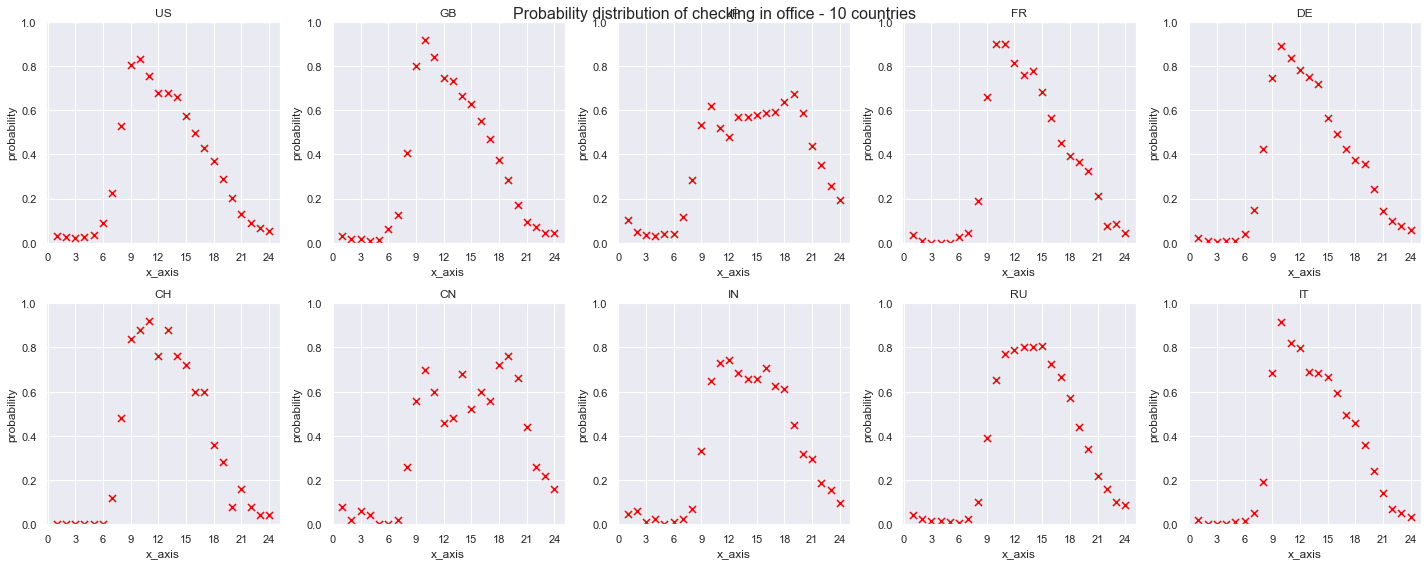

In [138]:
## probability distribution of checking in office - 10 countries
fig, axes = plt.subplots(2, 5, figsize = (20, 8))
countries = ['US', 'GB', 'JP', 'FR', 'DE', 'CH', 'CN', 'IN', 'RU', 'IT']
# countries = Office_perUser['Country Code'].unique().tolist()
idx = 0
for axs in axes:
    for ax in axs:
        df = Office_perUser[Office_perUser['Country Code'] == countries[idx]]
        prob = calculateProb(df)
        prob.plot.scatter(x = 'x_axis', y = 'probability', s = 50, ax = ax, color = 'red', marker = 'x')

        positions = [0, 180, 360, 540, 720, 900, 1080, 1260, 1440]
        labels = ["0", "3", "6", "9", "12", "15", "18", "21", "24"]
        ax.set_xticks(positions)
        ax.set_xticklabels(labels)
        ax.set_title(countries[idx])
        ax.set_ylim(0, 1)
        idx += 1
plt.suptitle("Probability distribution of checking in office - 10 countries", fontsize = 16)
plt.tight_layout()

#### Examples: visualize the periodic behaviors in US and Japan

In [140]:
HomeOffice_perUser = pd.merge(Home_perUser, Office_perUser, \
                      left_index = True, right_index = True, suffixes=('_home', '_office'), how = 'inner').reset_index()
HomeOffice_perUser['home count'] = HomeOffice_perUser['time_home'].apply(lambda x: len(x))
HomeOffice_perUser['office count'] = HomeOffice_perUser['time_office'].apply(lambda x: len(x))
HomeOffice_perUser.head(5)

,UserID,time_home,Country Code_home,time_office,Country Code_office,home count,office count
0,19,"[1270, 535]",US,"[724, 1089, 651, 580]",US,2,4
1,54,[885],US,"[849, 816, 514, 945]",BR,1,4
2,58,[1134],US,"[1145, 1177, 831]",US,1,3
3,75,"[1343, 1296, 20, 998, 953, 936, 1397, 946]",PH,[811],PH,8,1
4,120,"[829, 1237]",US,[954],US,2,1


In [141]:
## filter out examples in US, take those people with home and office count more than 10
US_time = HomeOffice_perUser[HomeOffice_perUser['Country Code_home'] == 'US']
US_time = US_time[(US_time['home count'] > 10) & (US_time['office count'] > 10)]

## filter out examples in Japan, take those people with home and office count more than 10
JP_time = HomeOffice_perUser[HomeOffice_perUser['Country Code_home'] == 'JP']
JP_time = JP_time[(JP_time['home count'] > 10) & (JP_time['office count'] > 10)]

In [142]:
def periodicVisualiztion(df, axes, country):
    idx = 0
    for axs in axes:
        for ax in axs:
            x = df['time_home'].values[idx]
            y = [0 for i in range(len(x))]
            ax.scatter(x, y, s = 10, color = 'red', marker = 'x', label = 'home')
            x = df['time_office'].values[idx]
            y = [1 for i in range(len(x))]
            ax.scatter(x, y, s = 10, color = 'blue', marker = 'x', label = 'office')
            positions = [0, 360, 720, 1080, 1440]
            labels = ["0", "6", "12", "18", "24"]
            ax.set_xticks(positions)
            ax.set_xticklabels(labels)
            ax.set_yticks([]) 
            ax.legend()
            idx += 1
    plt.suptitle("Periodic behaviors of 20 users in " + country)
    plt.show()

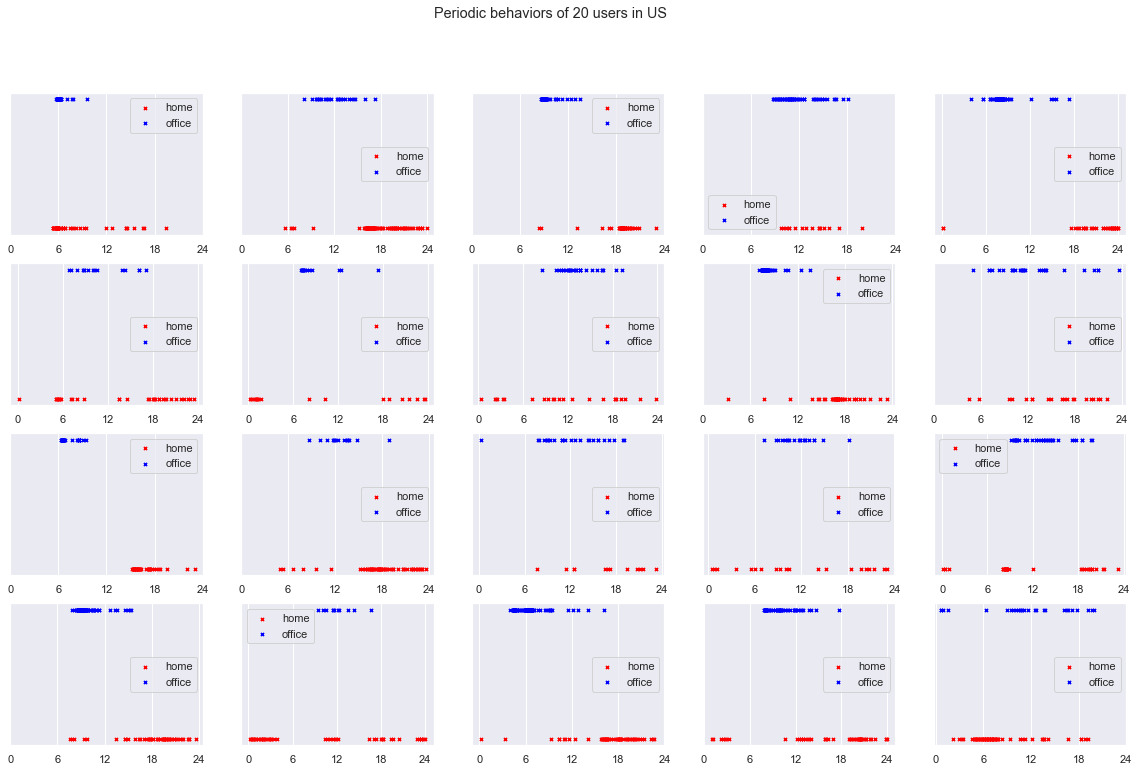

In [143]:
fig, axes = plt.subplots(4, 5, figsize = (20, 12))
periodicVisualiztion(US_time, axes, 'US')

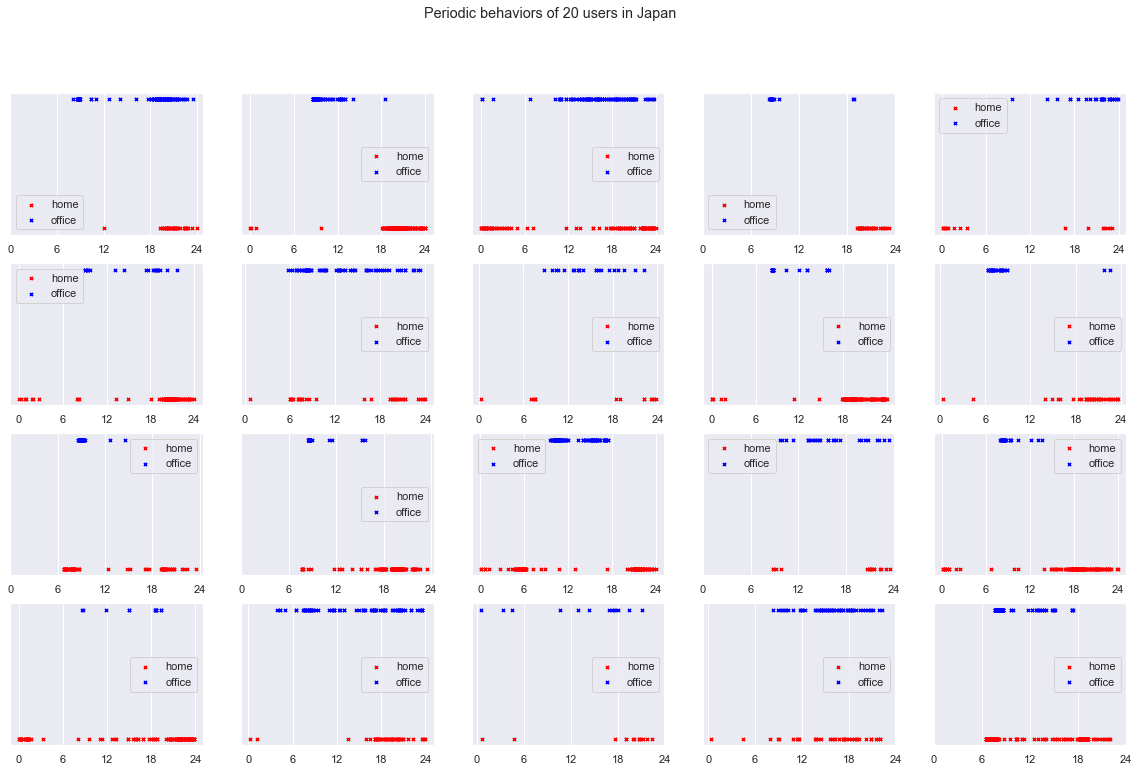

In [144]:
fig, axes = plt.subplots(4, 5, figsize = (20, 12))
periodicVisualiztion(JP_time, axes, 'Japan')